In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
quiz_df = pd.read_csv('/content/drive/My Drive/SIADS 699: Capstone/Clean Data/quiz_data_complete.csv')
quiz_test_df = pd.read_csv('/content/drive/My Drive/SIADS 699: Capstone/Clean Data/quiz_test_data.csv')

In [3]:
quiz_df.head()

,username,quiz_name,category,grade,timestamp,date,time,num_total,num_correct,percent_correct,mastery,mastery_timestamp,mastery_date,mastery_time
0,CharlotteC14,AS1,AS,1,2024-07-24 11:43:24,2024-07-24,11:43:24,5,5,1.00,0,2024-12-10 14:22:42,2024-12-10,14:22:42
1,CyrusC3,AS2,AS,2,2024-07-24 11:47:02,2024-07-24,11:47:02,5,5,1.00,0,2024-08-28 12:50:34,2024-08-28,12:50:34
2,CharlotteC14,MD3,MD,3,2024-07-24 11:49:29,2024-07-24,11:49:29,4,3,0.75,0,2025-01-28 15:06:53,2025-01-28,15:06:53
3,FoxF2,AS1,AS,1,2024-07-24 11:57:14,2024-07-24,11:57:14,5,5,1.00,0,2025-03-06 15:01:13,2025-03-06,15:01:13
4,KnoxK2,MD,NaN,4,2024-07-24 12:09:47,2024-07-24,12:09:47,5,3,0.60,0,NaN,NaN,NaN


In [4]:
quiz_test_df.head()

,username,quiz_name,category,grade,timestamp,date,time,num_total,num_correct,percent_correct,mastery,mastery_timestamp,mastery_date,mastery_time
0,CyrusC3,COM5,NaN,5,2025-02-13 09:42:58,2025-02-13,09:42:58,4,4,1.0,0,NaN,NaN,NaN
1,CyrusC3,COM5,NaN,5,2025-02-13 09:50:12,2025-02-13,09:50:12,4,4,1.0,0,NaN,NaN,NaN
2,OarielO,COM5,NaN,5,2025-02-13 10:00:06,2025-02-13,10:00:06,4,0,0.0,0,NaN,NaN,NaN
3,CyrusC3,COM5,NaN,5,2025-02-13 09:59:41,2025-02-13,09:59:41,4,4,1.0,0,NaN,NaN,NaN
4,CyrusC3,AS,AS,4,2025-02-13 10:04:45,2025-02-13,10:04:45,4,4,1.0,1,2025-01-13 11:13:26,2025-01-13,11:13:26


In [5]:
'''
Data Preparation: ensure timestamp columns are in datetime format, aggregate daily average percent_correct, convert index to datetime, and sort by date
'''
def prepare_data(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  daily_avg = df.groupby(df['timestamp'].dt.date)['percent_correct'].mean()
  daily_avg.index = pd.to_datetime(daily_avg.index)
  daily_avg = daily_avg.sort_index()
  return daily_avg

daily_avg = prepare_data(quiz_df)
daily_avg_test = prepare_data(quiz_test_df)

ADF Statistic: -3.8946153473514875
p-value: 0.002074834509032131
percent_correct is stationary, differencing not required set d=0
Best Order: (10, 0, 0)


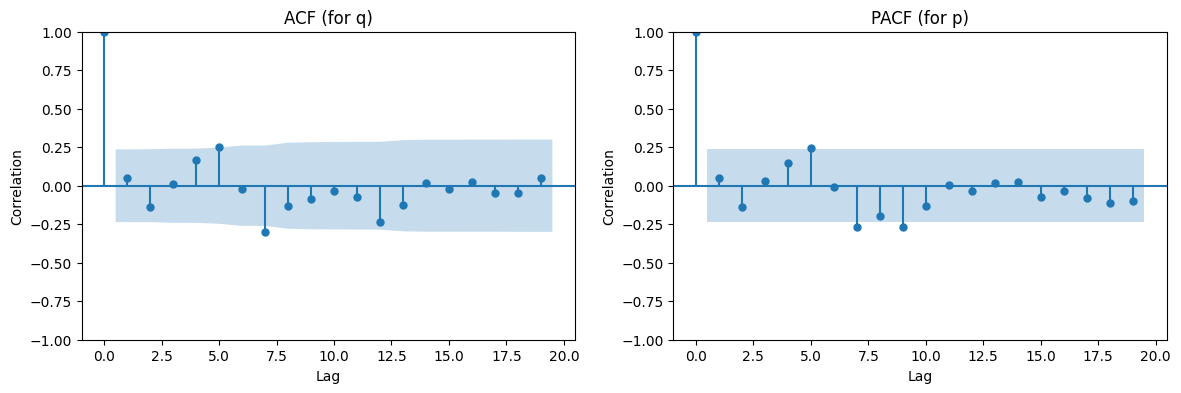

In [6]:
'''
ARIMA model training: all students, all topics
- run the ADF test on daily_avg for stationarity
- perform differencing if needed (depending on results of ADF)
- plot autocorrelation (ACF) and partional autocorrelation (PACF) to tune parameters
'''
def grid_search(series, d, p_range, q_range):
  best_aic = float('inf')
  best_order = None

  for p in p_range:
    for q in q_range:
      try:
        model = ARIMA(series, order=(p, d, q))
        results = model.fit()
        if results.aic < best_aic:
          best_aic = results.aic
          best_order = (p, d, q)
      except:
        continue

  return best_order

adf_result = adfuller(daily_avg.dropna())

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] <= 0.05:
  d=0
  print("percent_correct is stationary, differencing not required set d=0")
else:
  d=1
  print("percent_correct is not stationary, differencing is required set d=1")
  daily_avg = daily_avg.diff().dropna()
  adf_diff_result = adfuller(daily_avg)
  print(f'ADF Statistic (Differenced): {adf_diff_result[0]}')
  print(f'p-value (Differenced): {adf_diff_result[1]}')

order = grid_search(daily_avg, d, p_range=(0,10), q_range=(0,10))
print(f'Best Order: {order}')

fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(daily_avg, ax=axes[0])
axes[0].set_title('ACF (for q)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
plot_pacf(daily_avg, ax=axes[1])
axes[1].set_title('PACF (for p)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Correlation')
plt.show()

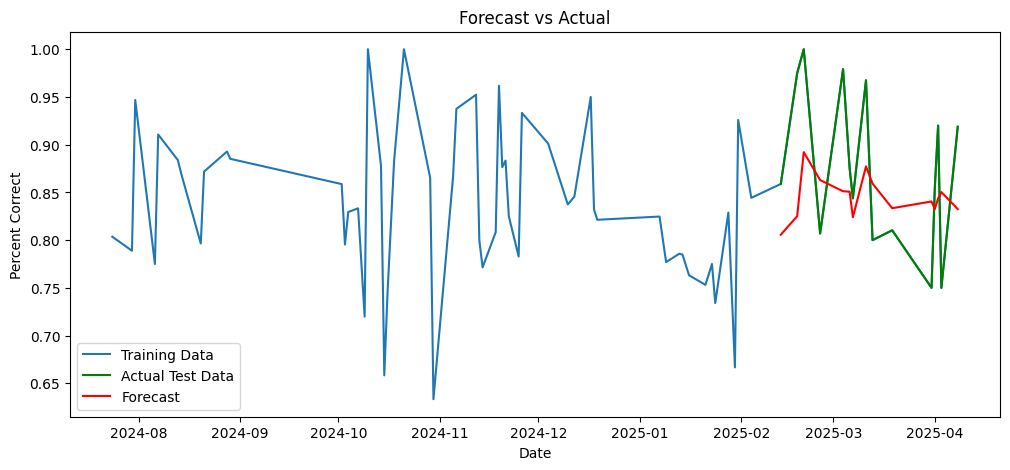

MAE: 0.07, RMSE: 0.08


In [7]:
'''
ARIMA model training: all students, all topics
- train model using parameters tuned above
- forecast the test data
- compare with actual test data
- calculate MAE and RMSE
- visualize forecast vs actual
'''

overall_model = ARIMA(daily_avg, order=order)
overall_results = overall_model.fit()

n_forecast = len(daily_avg_test)
forecast = overall_results.forecast(steps=n_forecast)
forecast.index = daily_avg_test.index

plt.figure(figsize=(12, 5))
plt.plot(daily_avg, label='Training Data')
plt.plot(daily_avg_test, label='Actual Test Data', color='green')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Percent Correct')
plt.show()

mae = mean_absolute_error(daily_avg_test, forecast)
mse = mean_squared_error(daily_avg_test, forecast)
rmse = mse ** 0.5

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

CharlotteC14
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.437486466218495
p-value: 0.13143438065212693
Best Order: (6, 1, 1)


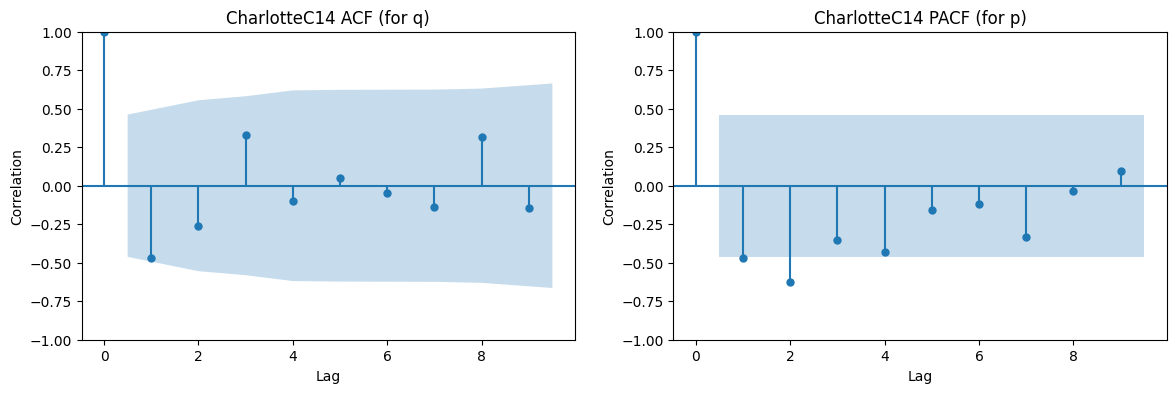

CyrusC3
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -3.813369109460927
p-value: 0.0027734554173901365
Best Order: (1, 0, 1)


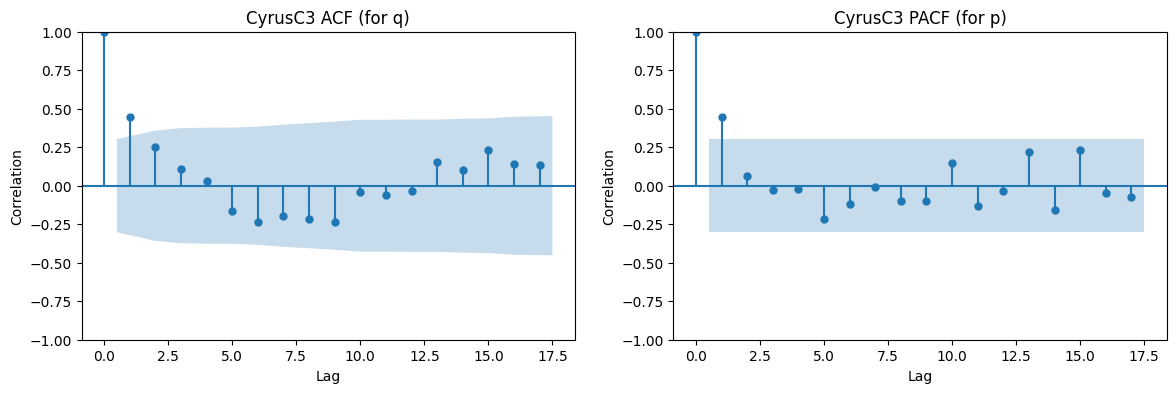

FoxF2
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -0.9613542564556653
p-value: 0.7670972980156212
Best Order: (6, 1, 1)


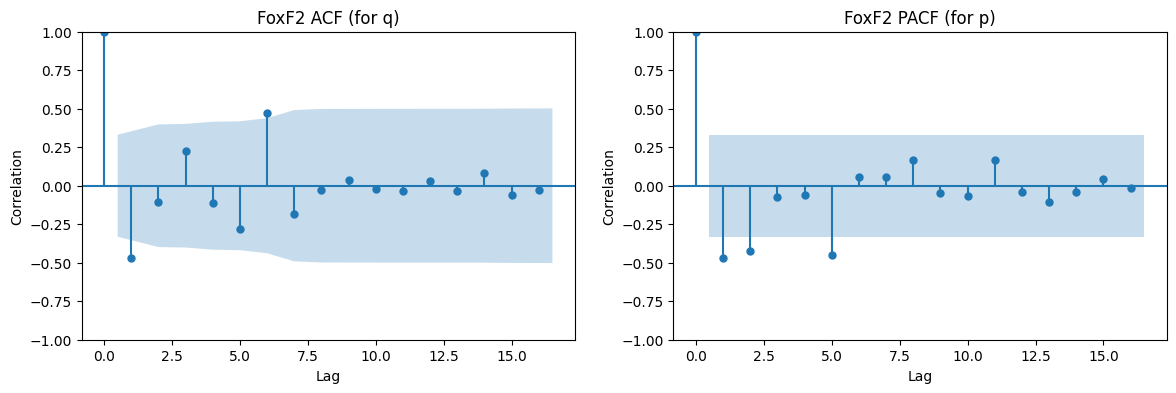

KnoxK2
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.318869339477786
p-value: 0.16595443185224645
Best Order: (6, 1, 1)


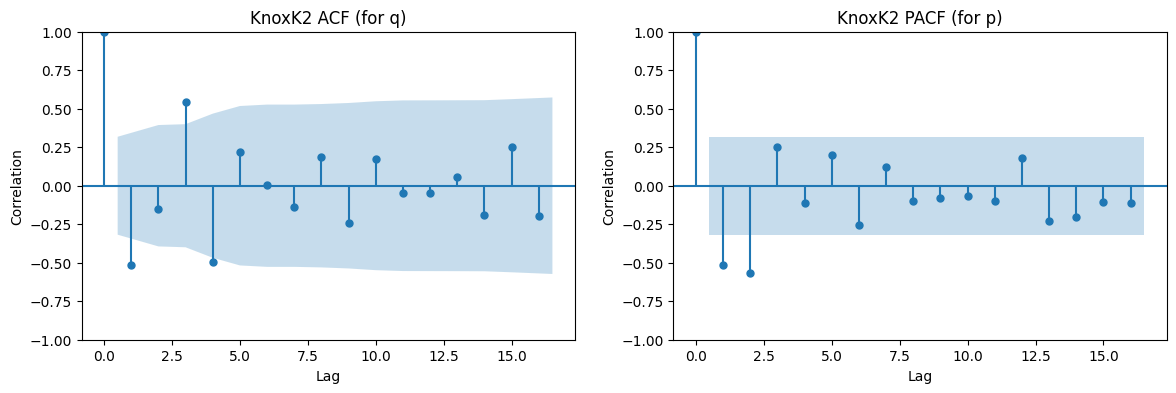

PaytonP4
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.577322768106639
p-value: 0.09777535016416311
Best Order: (6, 1, 1)


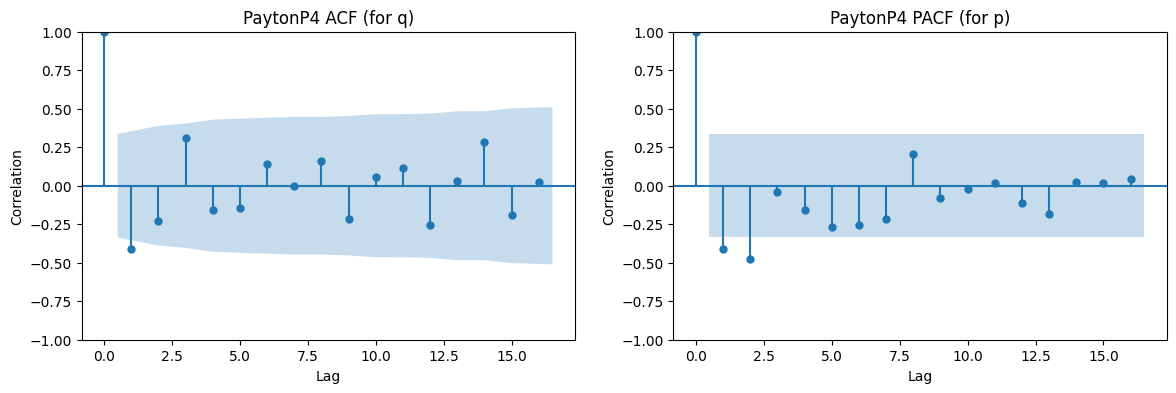

OarielO
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -1.629422034685263
p-value: 0.4677932579321218
Best Order: (1, 1, 1)


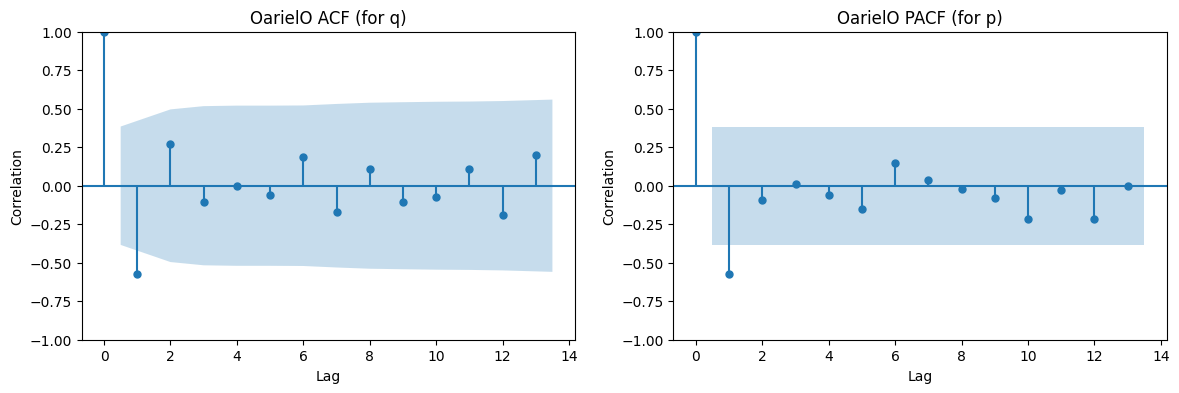

AyaA2
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -5.867152336626031
p-value: 3.3049544930853404e-07
Best Order: (1, 0, 1)


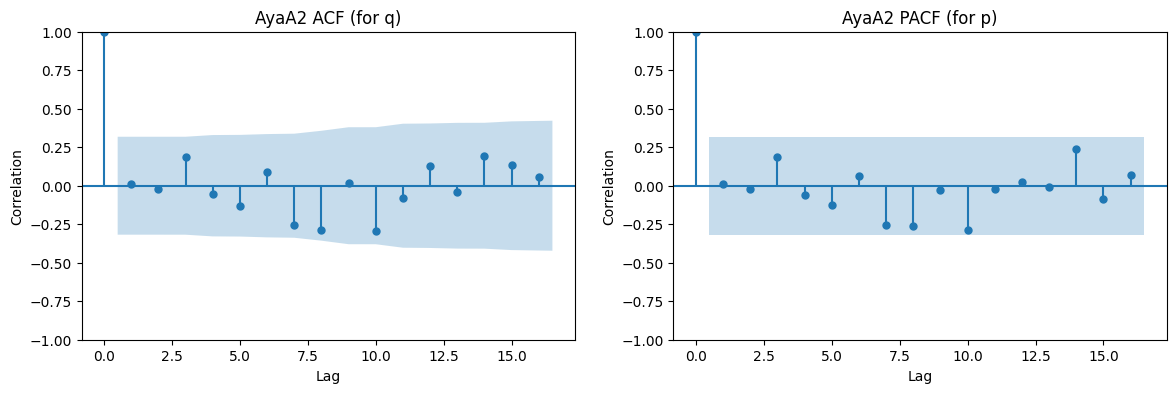

OamirO
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -2.955911421928937
p-value: 0.03922192089864981
Best Order: (1, 0, 1)


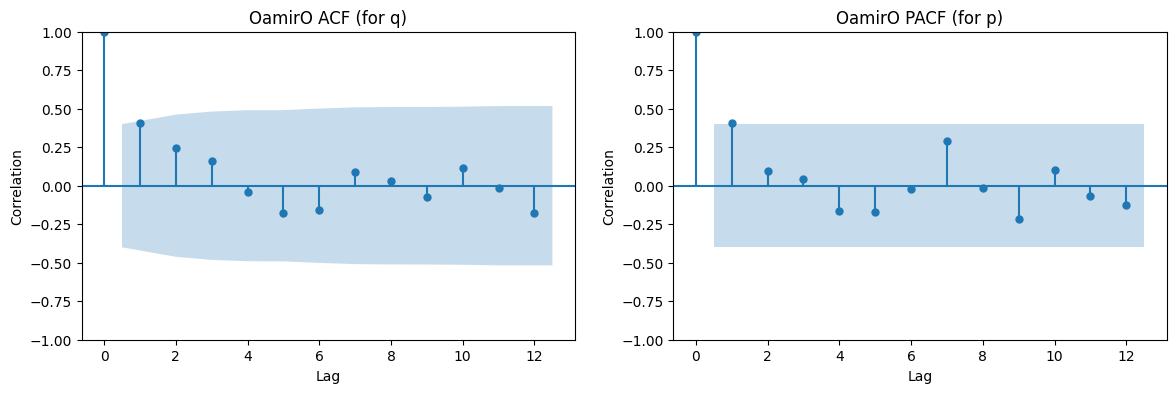

IyanaI
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: 3.5658506937777155
p-value: 1.0
Best Order: (1, 1, 1)


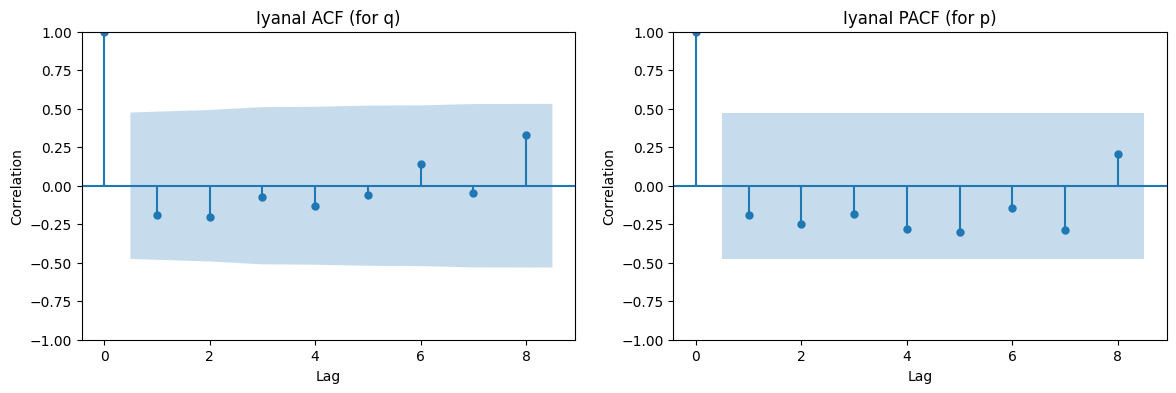

In [8]:
'''
ARIMA model training: individual student data
- prepare the data
- run the ADF test on daily_avg for stationarity
- perform differencing if needed (depending on results of ADF)
- plot autocorrelation (ACF) and partional autocorrelation (PACF) to visualize parameters
- use grid_search to find best parameters
'''

def student_tuning(username, p_range=(1,6), q_range=(1,10)):

  print(username)

  student_df = quiz_df[quiz_df['username'] == username]
  daily_avg_student = prepare_data(student_df)
  daily_avg_student_test = prepare_data(quiz_test_df[quiz_test_df['username'] == username])

  d = 0
  adf_result = adfuller(daily_avg_student.dropna())
  if adf_result[1] <= 0.05:
    print("percent_correct is stationary, differencing not required (set d=0)")
  else:
    print("percent_correct is not stationary, differencing is required (set d=1)")
    daily_avg_student = daily_avg_student.diff().dropna()
    adf_diff_result = adfuller(daily_avg_student)
    d = 1

  print(f'ADF Statistic: {adf_result[0]}')
  print(f'p-value: {adf_result[1]}')

  best_order = grid_search(daily_avg_student, d, p_range, q_range)
  print(f'Best Order: {best_order}')


  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  plot_acf(daily_avg_student, ax=axes[0])
  axes[0].set_title(f'{username} ACF (for q)')
  axes[0].set_xlabel('Lag')
  axes[0].set_ylabel('Correlation')
  plot_pacf(daily_avg_student, ax=axes[1])
  axes[1].set_title(f'{username} PACF (for p)')
  axes[1].set_xlabel('Lag')
  axes[1].set_ylabel('Correlation')
  plt.show()

  return [daily_avg_student, daily_avg_student_test, best_order]

usernames = quiz_df['username'].unique()

for username in usernames:
  student_tuning(username)

CharlotteC14
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.437486466218495
p-value: 0.13143438065212693
Best Order: (6, 1, 1)


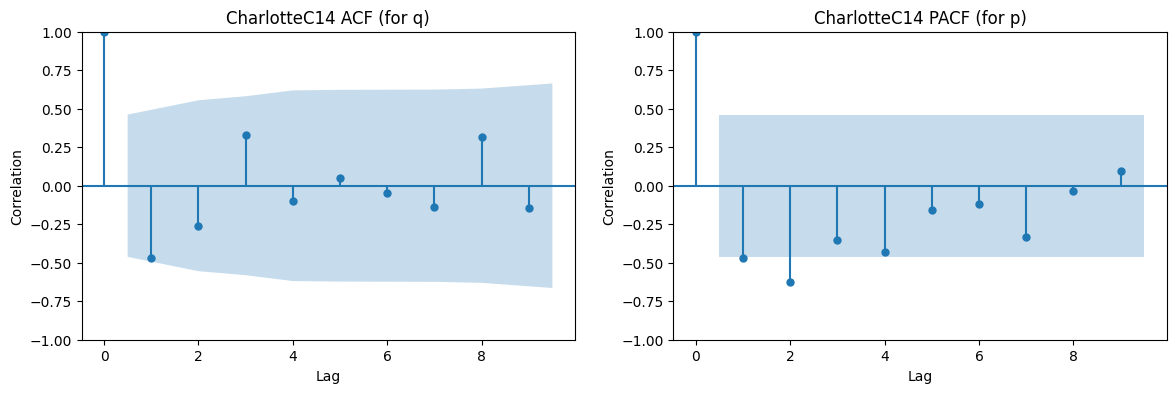

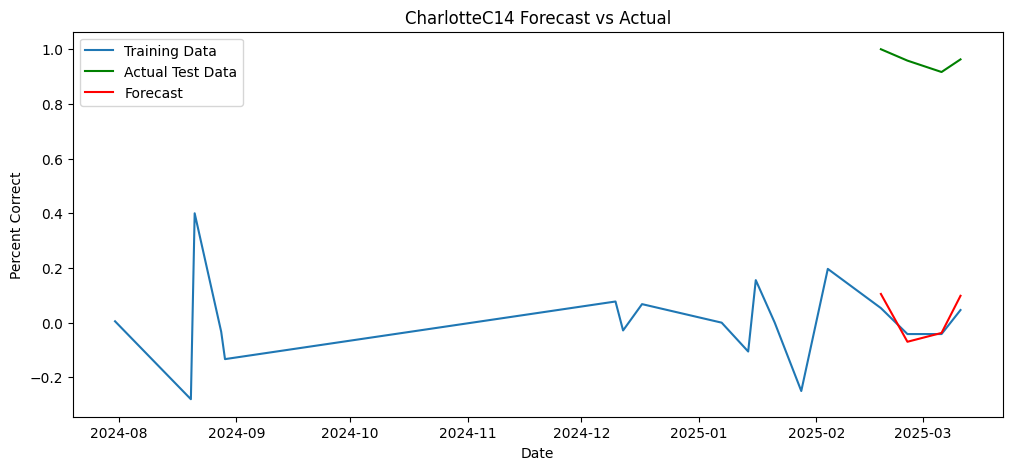

MAE: 0.94, RMSE: 0.94
CyrusC3
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -3.813369109460927
p-value: 0.0027734554173901365
Best Order: (1, 0, 1)


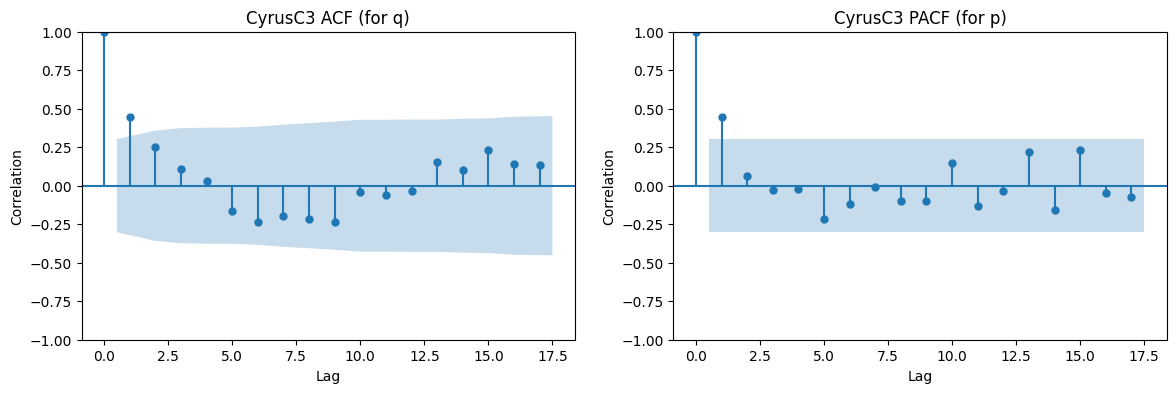

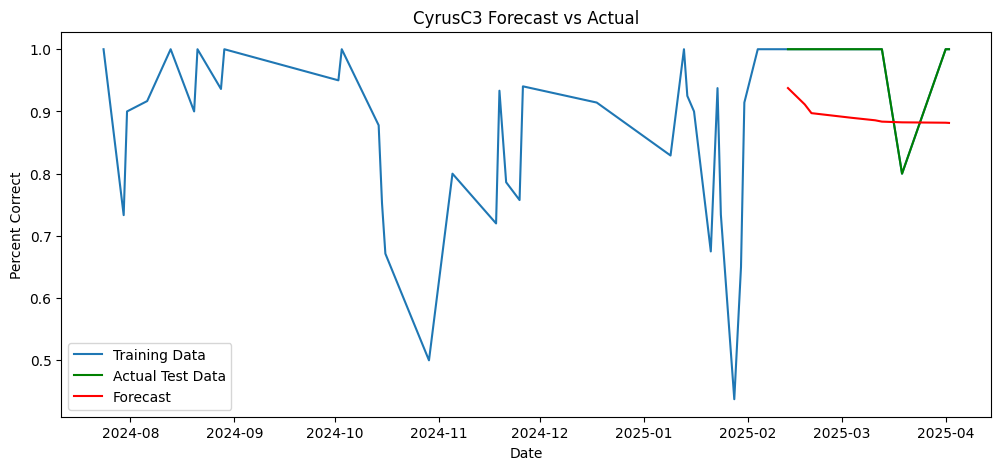

MAE: 0.10, RMSE: 0.10
FoxF2
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -0.9613542564556653
p-value: 0.7670972980156212
Best Order: (6, 1, 1)


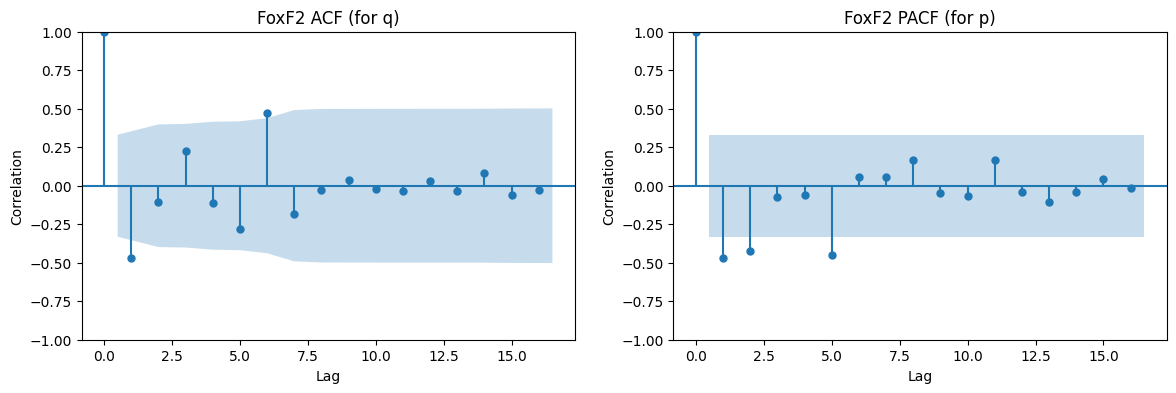

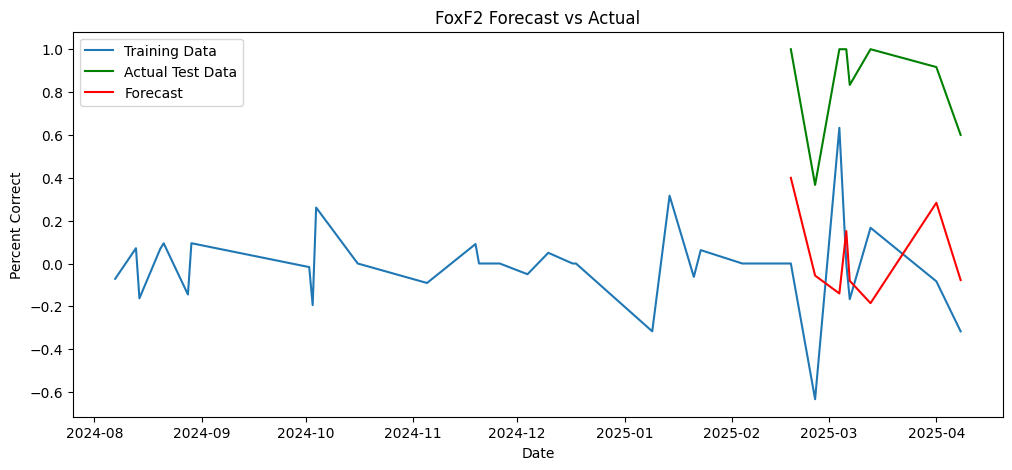

MAE: 0.80, RMSE: 0.84
KnoxK2
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.318869339477786
p-value: 0.16595443185224645
Best Order: (6, 1, 1)


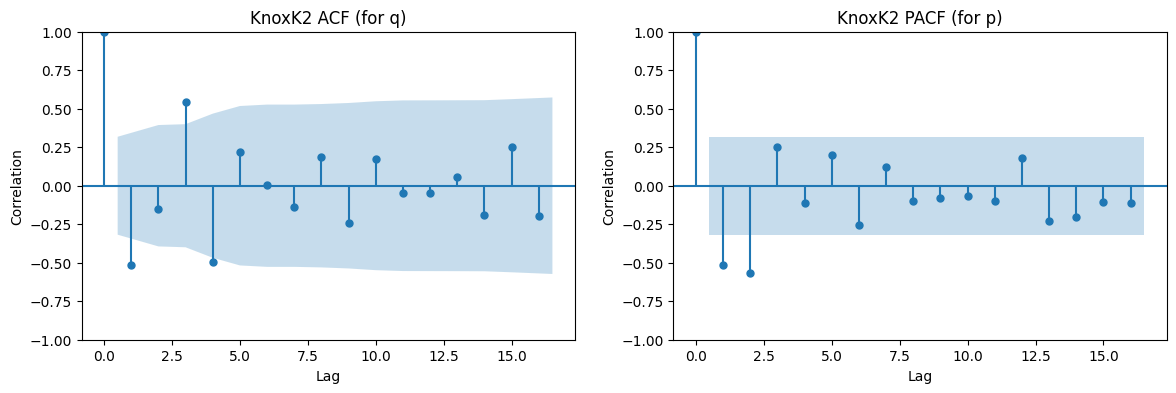

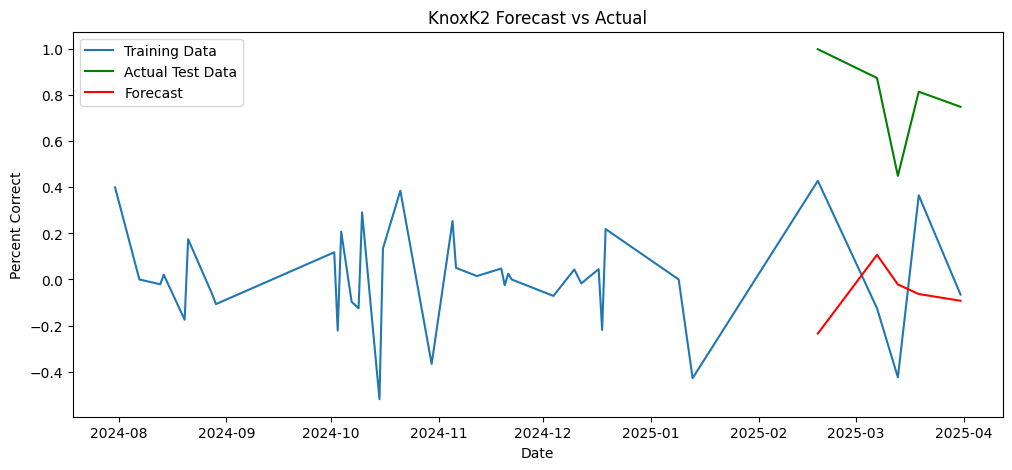

MAE: 0.84, RMSE: 0.87
PaytonP4
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.577322768106639
p-value: 0.09777535016416311
Best Order: (6, 1, 1)


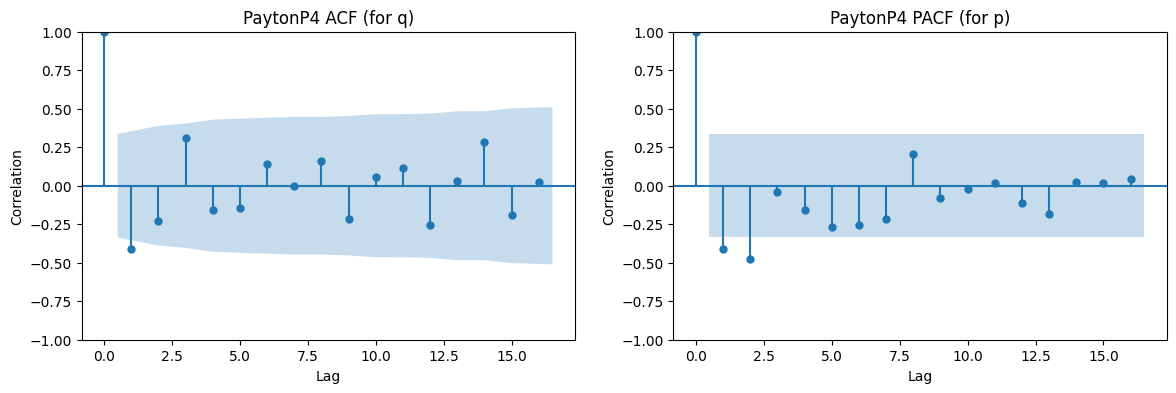

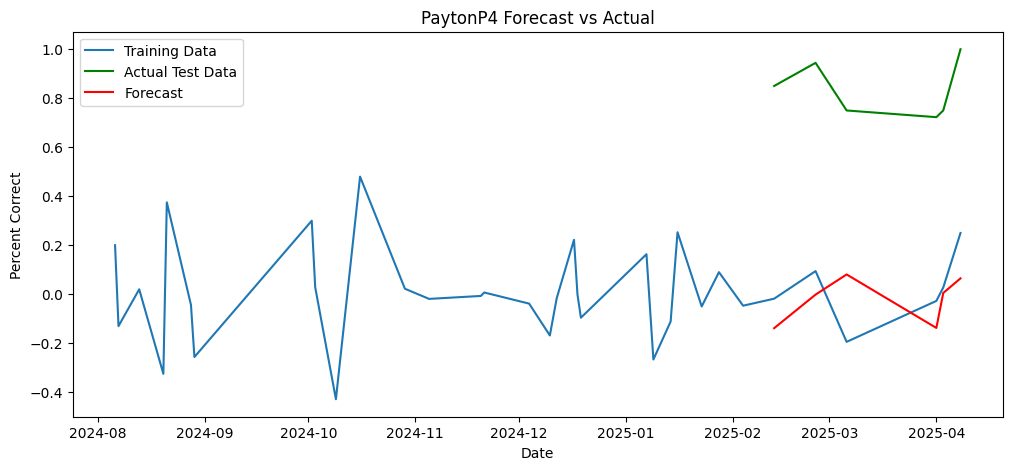

MAE: 0.86, RMSE: 0.87
OarielO
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -1.629422034685263
p-value: 0.4677932579321218
Best Order: (1, 1, 1)


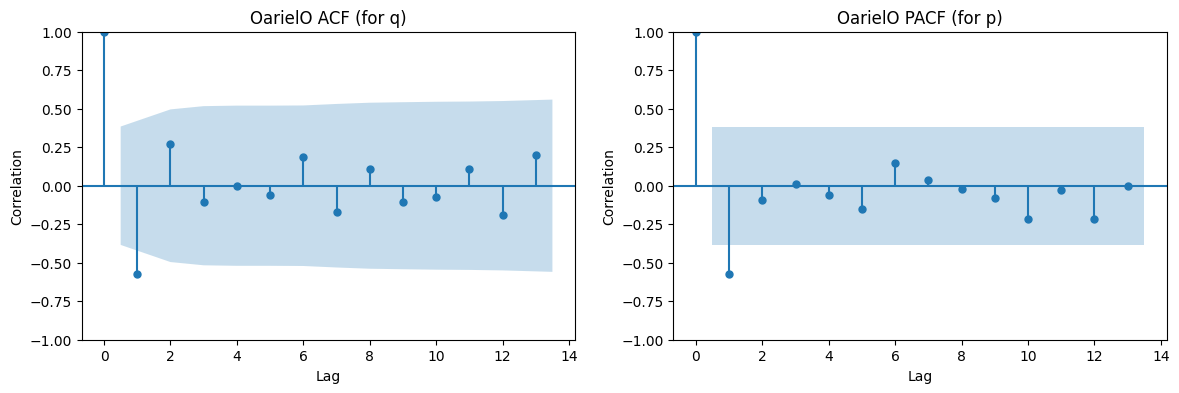

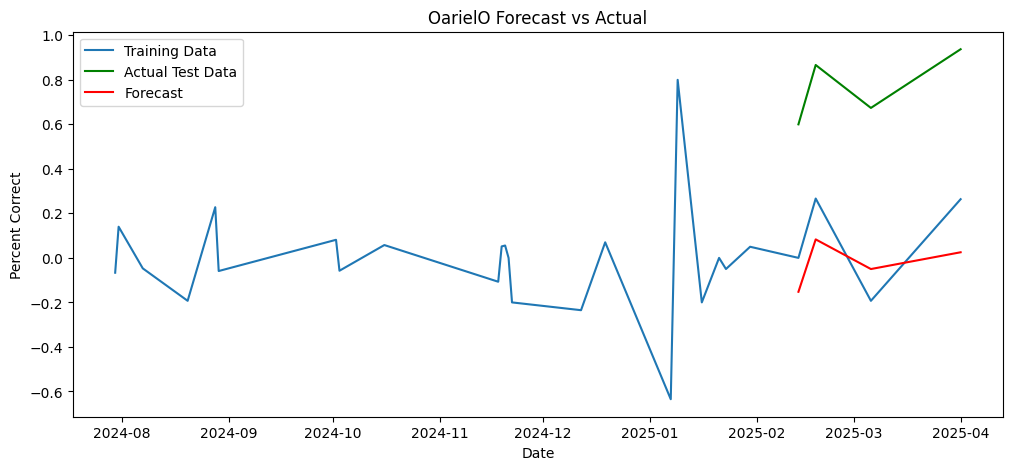

MAE: 0.79, RMSE: 0.80
AyaA2
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -5.867152336626031
p-value: 3.3049544930853404e-07
Best Order: (1, 0, 1)


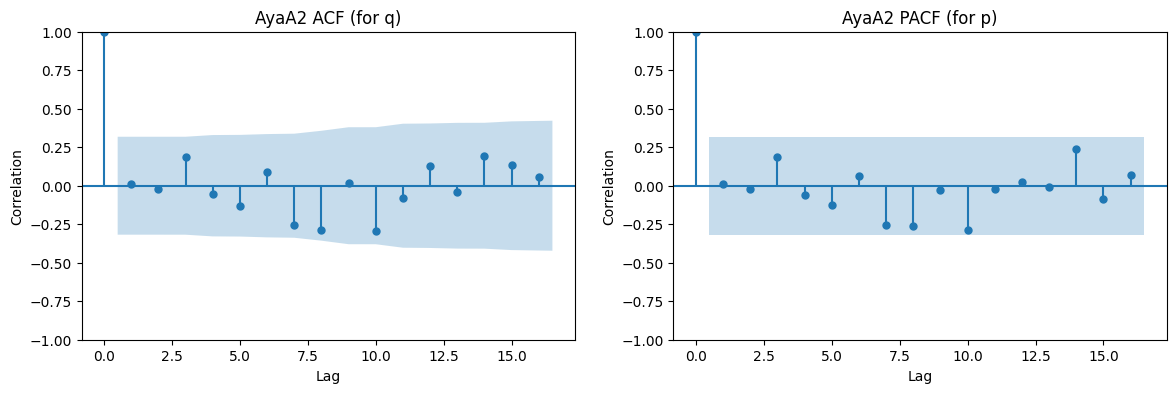

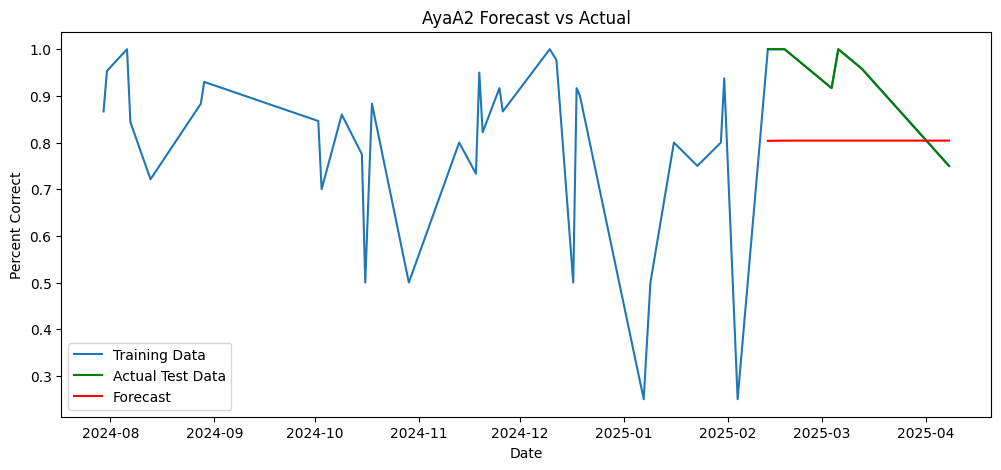

MAE: 0.15, RMSE: 0.16
OamirO
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -2.955911421928937
p-value: 0.03922192089864981
Best Order: (1, 0, 1)


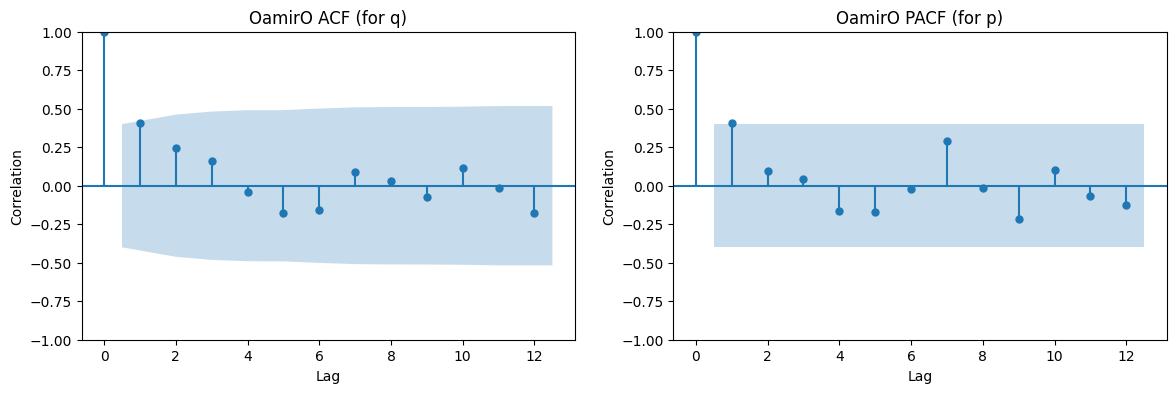

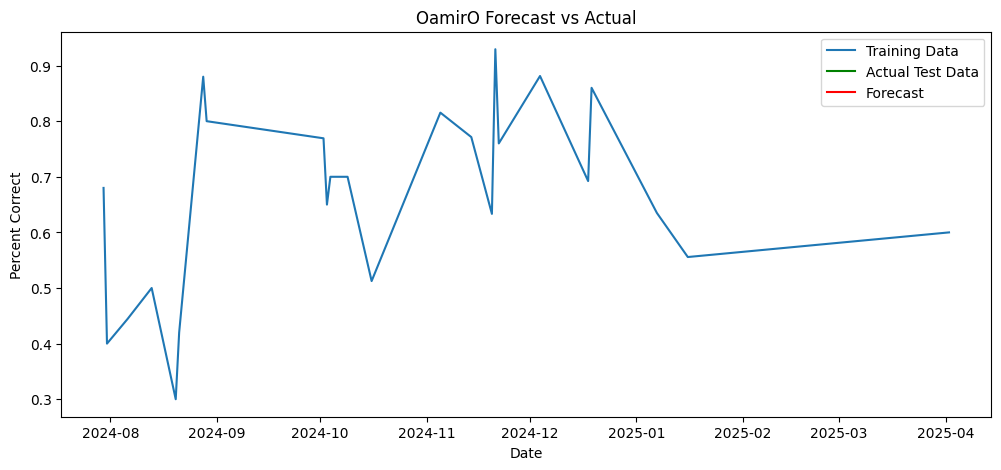

MAE: 0.03, RMSE: 0.03
IyanaI
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: 3.5658506937777155
p-value: 1.0
Best Order: (1, 1, 1)


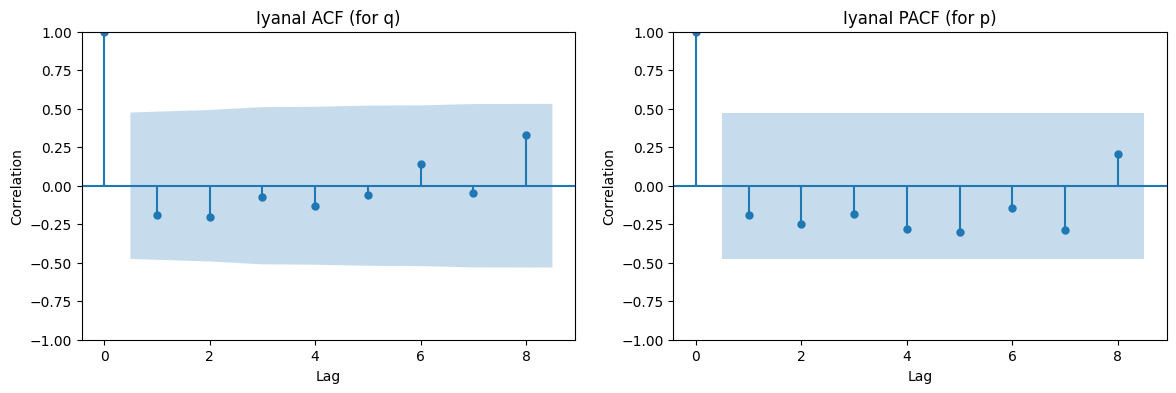

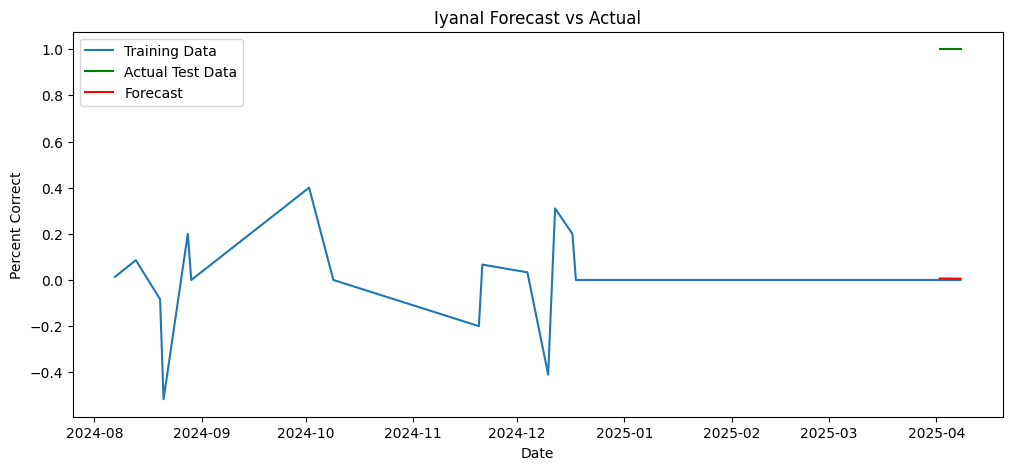

MAE: 0.99, RMSE: 0.99
Average MSE: 0.53
Average MAE: 0.61
Average RMSE: 0.62


In [9]:
'''
ARIMA model training: individual student data
- train model using parameters tuned above
- forecast the test data
- compare with actual test data
- calculate MAE and RMSE
- visualize forecast vs actual
'''

mses = []
maes = []
rmses = []

def student_forecast(username):

  daily_avg_student, daily_avg_student_test, order = student_tuning(username)
  if order == (0, 0, 0):
    order = (1, 0, 1)

  student_model = ARIMA(daily_avg_student, order=order)
  student_results = student_model.fit()

  n_forecast = len(daily_avg_student_test)
  forecast = student_results.forecast(steps=n_forecast)
  forecast.index = daily_avg_student_test.index

  plt.figure(figsize=(12, 5))
  plt.plot(daily_avg_student, label='Training Data')
  plt.plot(daily_avg_student_test, label='Actual Test Data', color='green')
  plt.plot(forecast, label='Forecast', color='red')
  plt.legend()
  plt.title(f'{username} Forecast vs Actual')
  plt.xlabel('Date')
  plt.ylabel('Percent Correct')
  plt.show()

  mae = mean_absolute_error(daily_avg_student_test, forecast)
  mse = mean_squared_error(daily_avg_student_test, forecast)
  rmse = mse ** 0.5

  mses.append(mse)
  maes.append(mae)
  rmses.append(rmse)

  print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

for username in usernames:
  student_forecast(username)

av_mse = np.mean(mses)
av_mae = np.mean(maes)
av_rmse = np.mean(rmses)

print(f'Average MSE: {av_mse:.2f}')
print(f'Average MAE: {av_mae:.2f}')
print(f'Average RMSE: {av_rmse:.2f}')

CharlotteC14
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.437486466218495
p-value: 0.13143438065212693
Best Order: (6, 1, 1)


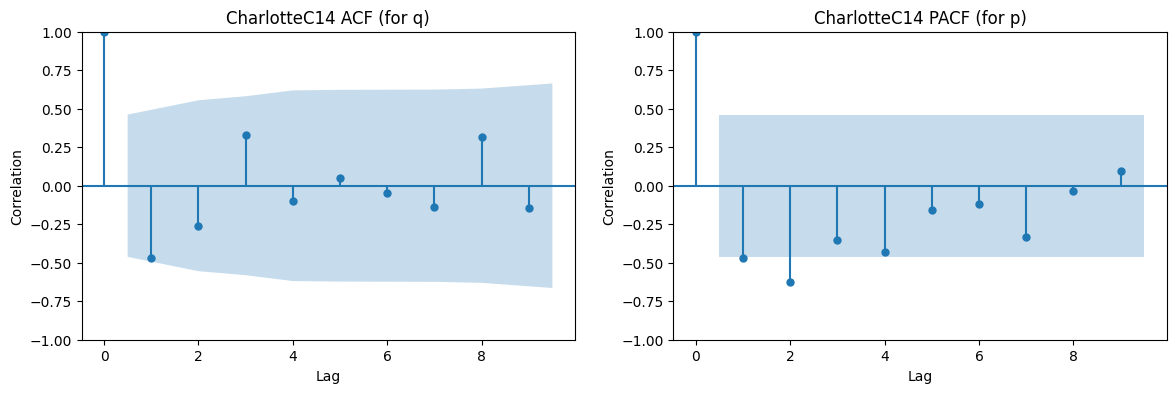

Order used for training: (2, 1, 1)


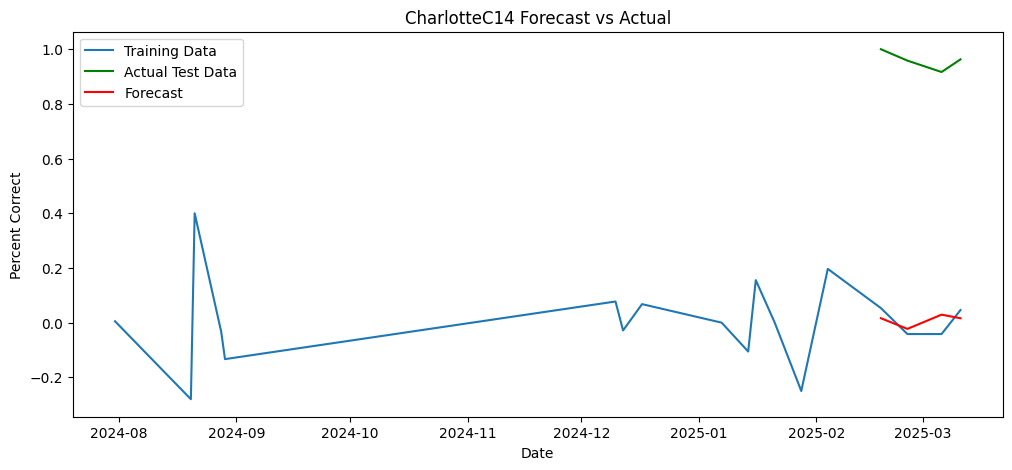

MAE: 0.95, RMSE: 0.95
CyrusC3
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -3.813369109460927
p-value: 0.0027734554173901365
Best Order: (1, 0, 1)


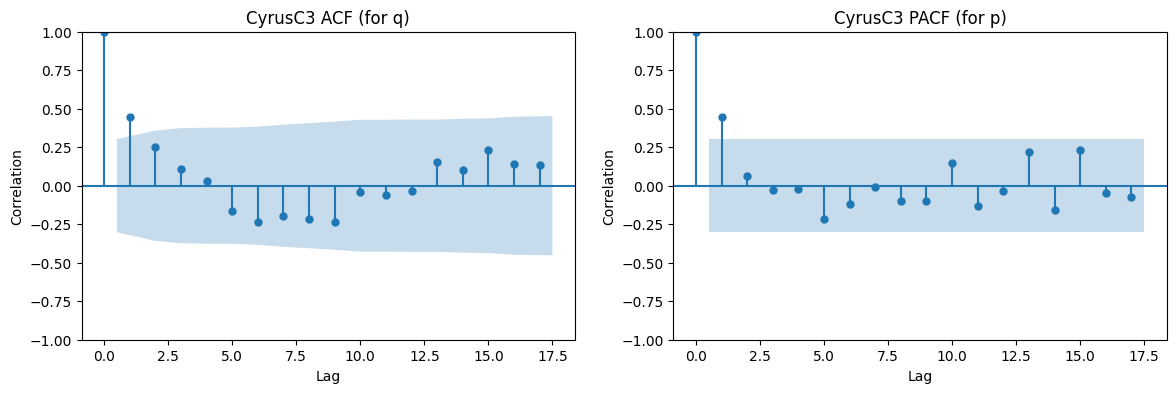

Order used for training: (1, 0, 1)


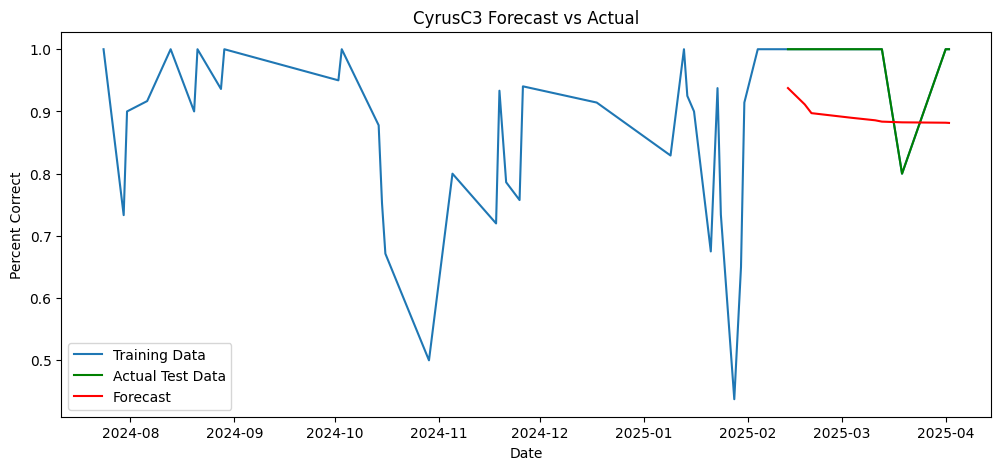

MAE: 0.10, RMSE: 0.10
FoxF2
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -0.9613542564556653
p-value: 0.7670972980156212
Best Order: (6, 1, 1)


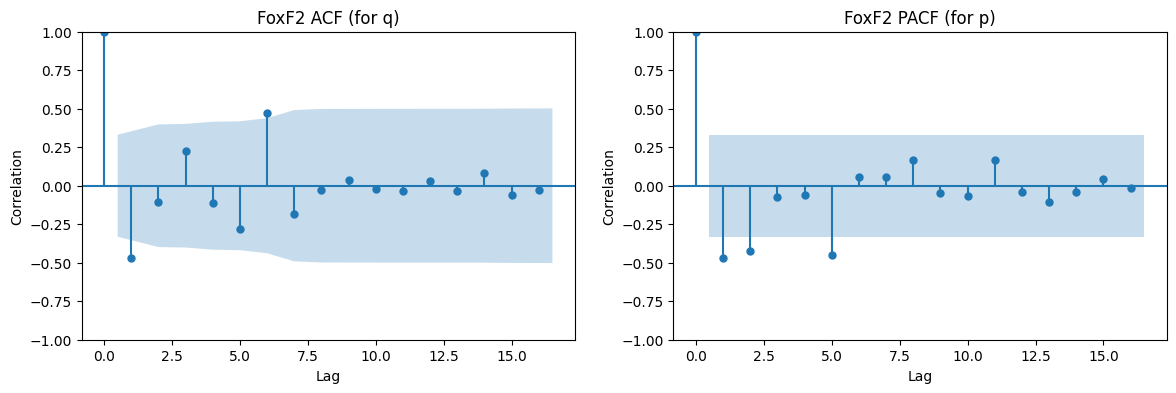

Order used for training: (5, 1, 6)


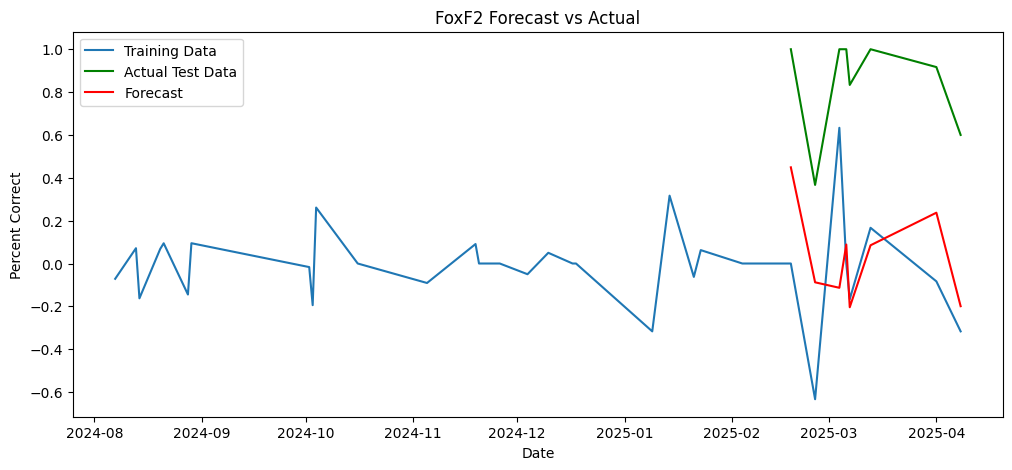

MAE: 0.81, RMSE: 0.84
KnoxK2
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.318869339477786
p-value: 0.16595443185224645
Best Order: (6, 1, 1)


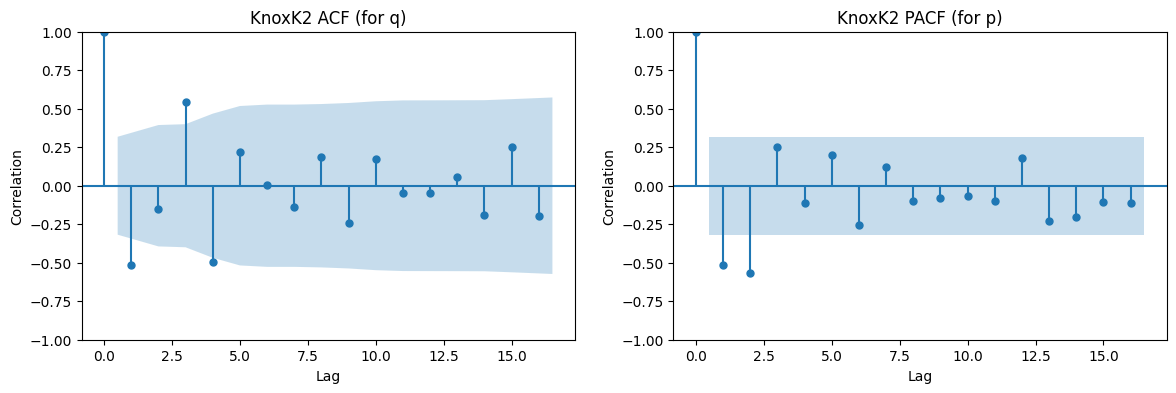

Order used for training: (2, 1, 3)


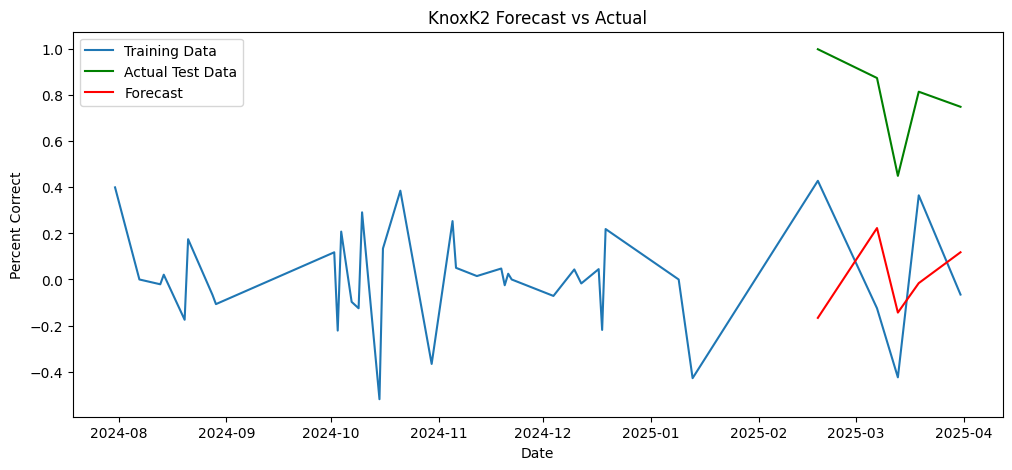

MAE: 0.78, RMSE: 0.80
PaytonP4
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.577322768106639
p-value: 0.09777535016416311
Best Order: (6, 1, 1)


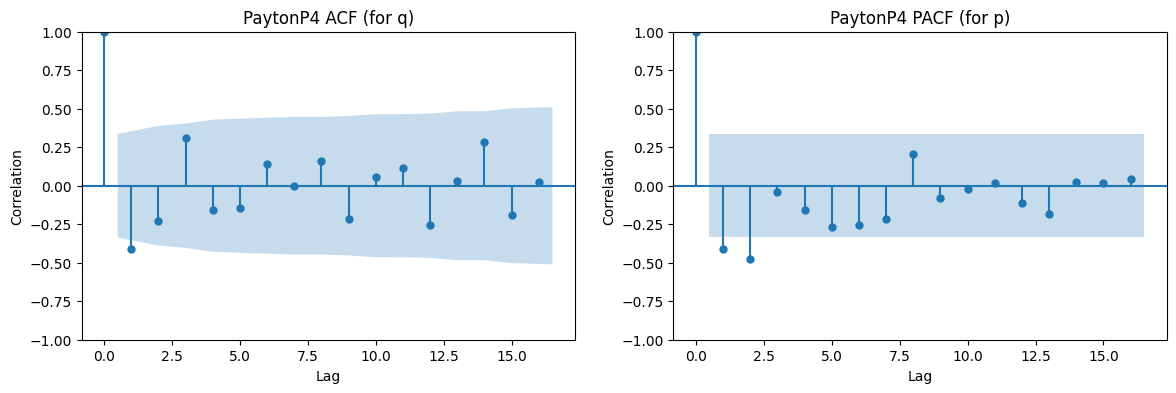

Order used for training: (2, 1, 1)


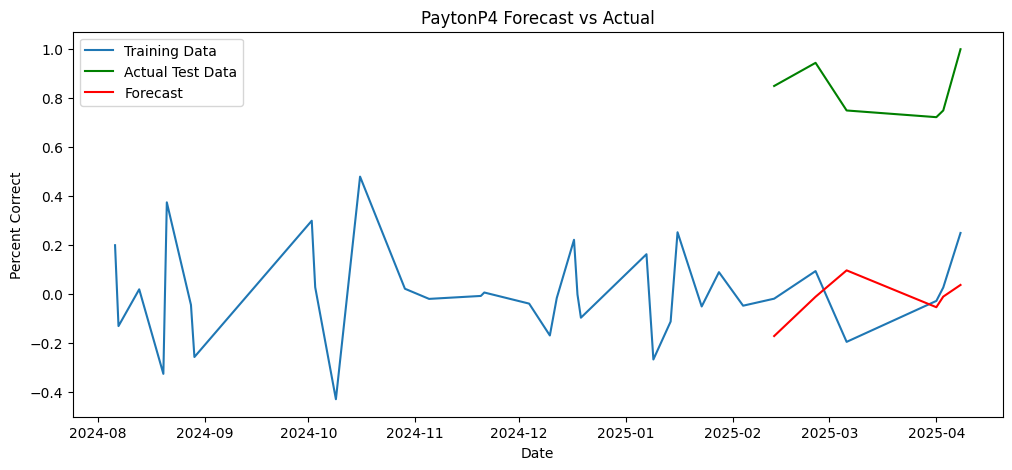

MAE: 0.85, RMSE: 0.86
OarielO
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -1.629422034685263
p-value: 0.4677932579321218
Best Order: (1, 1, 1)


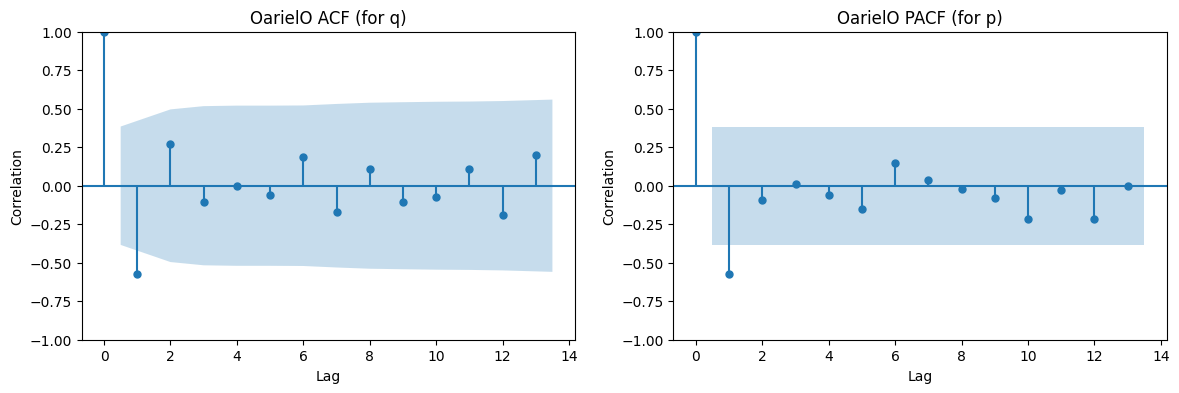

Order used for training: (1, 1, 1)


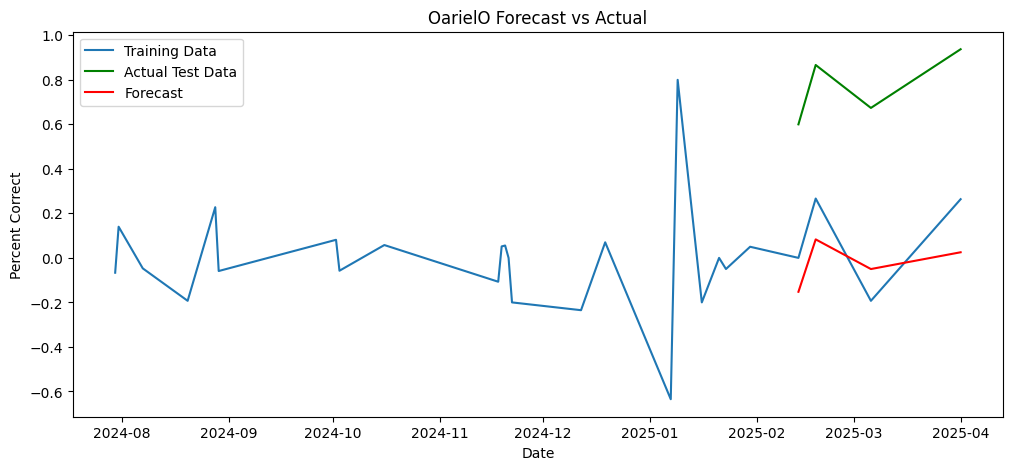

MAE: 0.79, RMSE: 0.80
AyaA2
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -5.867152336626031
p-value: 3.3049544930853404e-07
Best Order: (1, 0, 1)


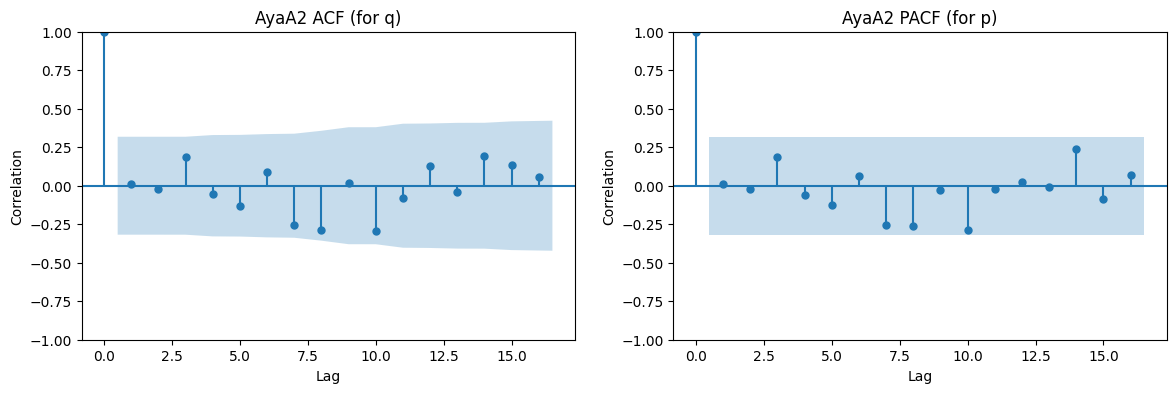

Order used for training: (1, 0, 1)


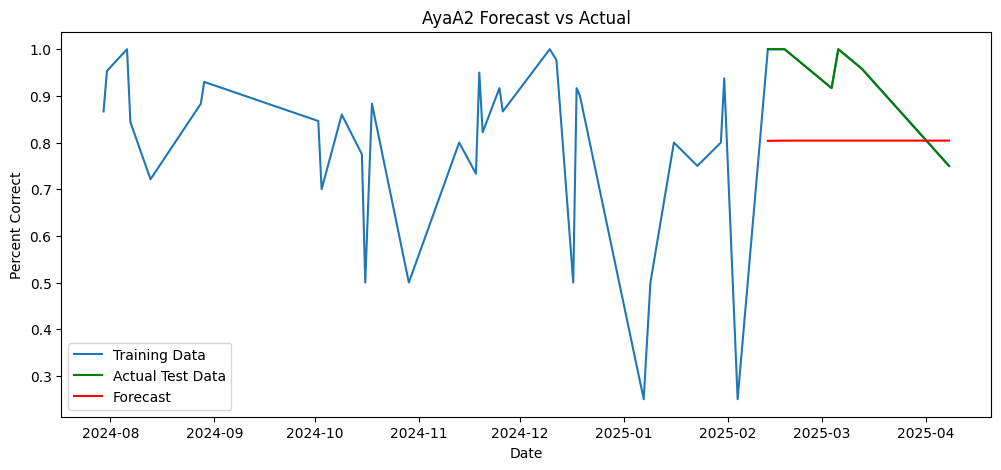

MAE: 0.15, RMSE: 0.16
OamirO
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -2.955911421928937
p-value: 0.03922192089864981
Best Order: (1, 0, 1)


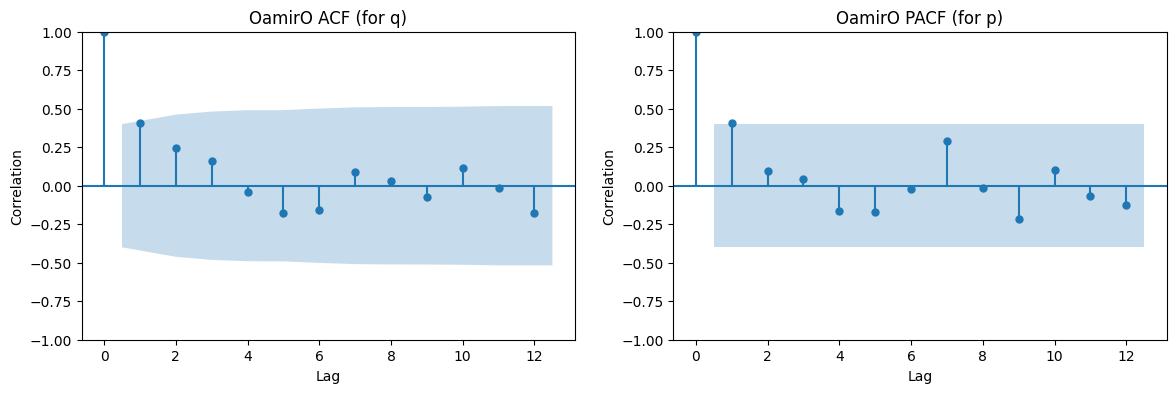

Order used for training: (1, 0, 1)


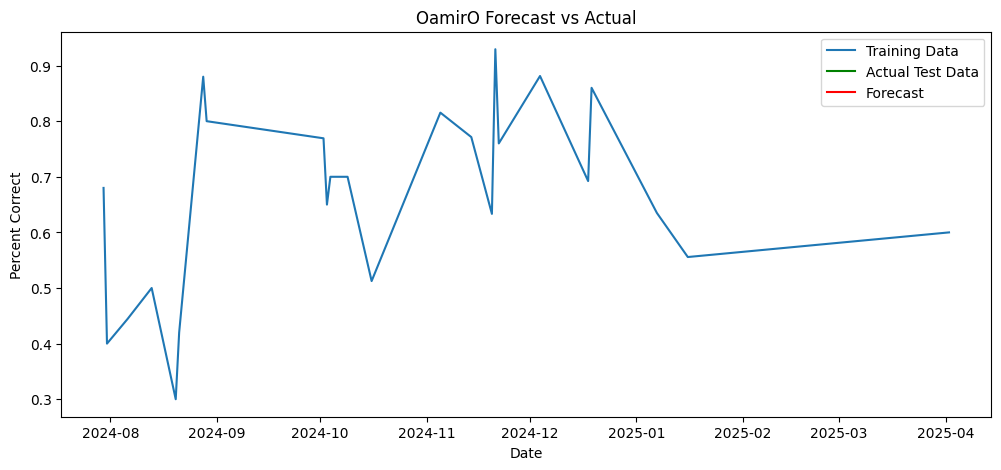

MAE: 0.03, RMSE: 0.03
IyanaI
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: 3.5658506937777155
p-value: 1.0
Best Order: (1, 1, 1)


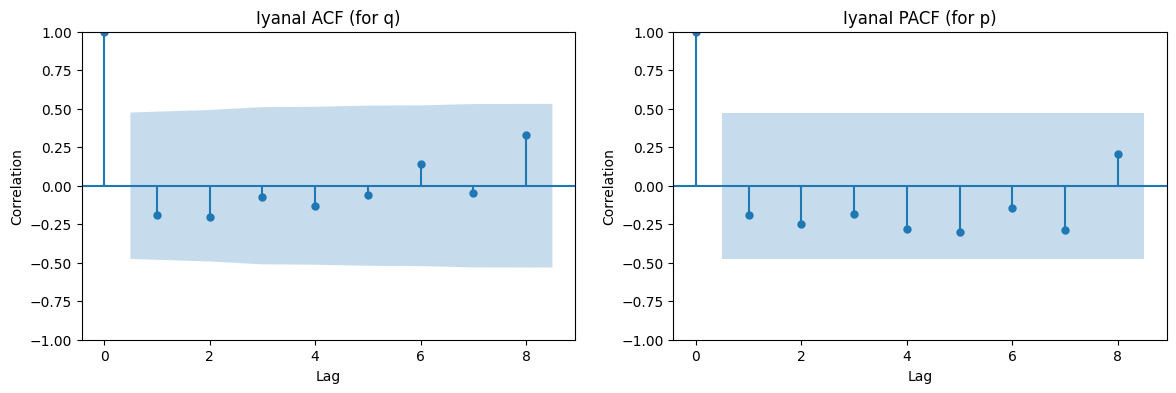

Order used for training: (1, 1, 1)


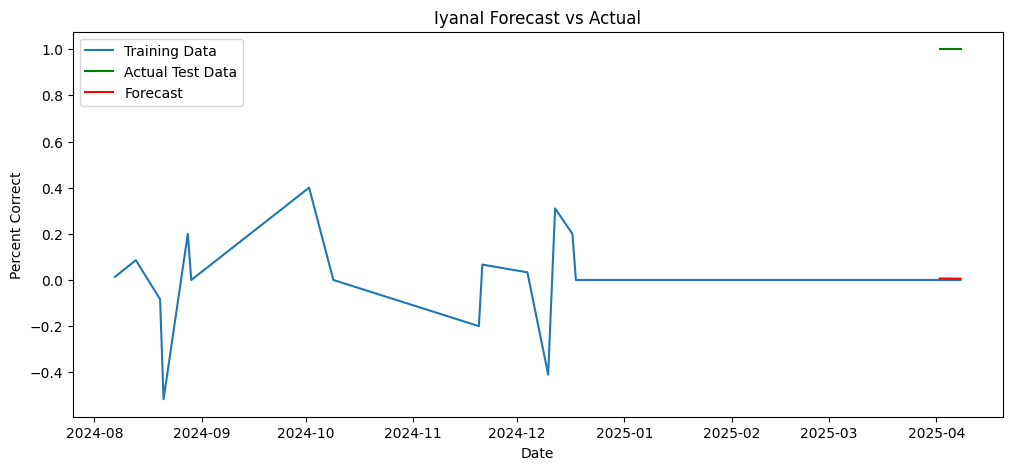

MAE: 0.99, RMSE: 0.99
Average MSE: 0.52
Average MAE: 0.61
Average RMSE: 0.62


In [10]:
'''
ARIMA model training: individual student data
- manually set parameters using ACF and PACF plots
- train model using manual parameters
- forecast the test data
- compare with actual test data
- calculate MAE and RMSE
- visualize forecast vs actual
'''

student_params = {
    'IyanaI': (1, 1, 1),
    'OamirO': (1, 0, 1),
    'AyaA2': (1, 0, 1),
    'OarielO': (1, 1, 1),
    'PaytonP4': (2, 1, 1),
    'KnoxK2': (2, 1, 3),
    'FoxF2': (5, 1, 6),
    'CyrusC3': (1, 0, 1),
    'CharlotteC14': (2, 1, 1)
}

mses = []
maes = []
rmses = []

def student_forecast(username):

  daily_avg_student, daily_avg_student_test, _ = student_tuning(username)
  order = student_params[username]

  print (f'Order used for training: {order}')

  student_model = ARIMA(daily_avg_student, order=order)
  student_results = student_model.fit()

  n_forecast = len(daily_avg_student_test)
  forecast = student_results.forecast(steps=n_forecast)
  forecast.index = daily_avg_student_test.index

  plt.figure(figsize=(12, 5))
  plt.plot(daily_avg_student, label='Training Data')
  plt.plot(daily_avg_student_test, label='Actual Test Data', color='green')
  plt.plot(forecast, label='Forecast', color='red')
  plt.legend()
  plt.title(f'{username} Forecast vs Actual')
  plt.xlabel('Date')
  plt.ylabel('Percent Correct')
  plt.show()

  mae = mean_absolute_error(daily_avg_student_test, forecast)
  mse = mean_squared_error(daily_avg_student_test, forecast)
  rmse = mse ** 0.5

  mses.append(mse)
  maes.append(mae)
  rmses.append(rmse)

  print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

for username in usernames:
  student_forecast(username)

av_mse = np.mean(mses)
av_mae = np.mean(maes)
av_rmse = np.mean(rmses)

print(f'Average MSE: {av_mse:.2f}')
print(f'Average MAE: {av_mae:.2f}')
print(f'Average RMSE: {av_rmse:.2f}')

CharlotteC14
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.437486466218495
p-value: 0.13143438065212693
Best Order: (6, 1, 1)


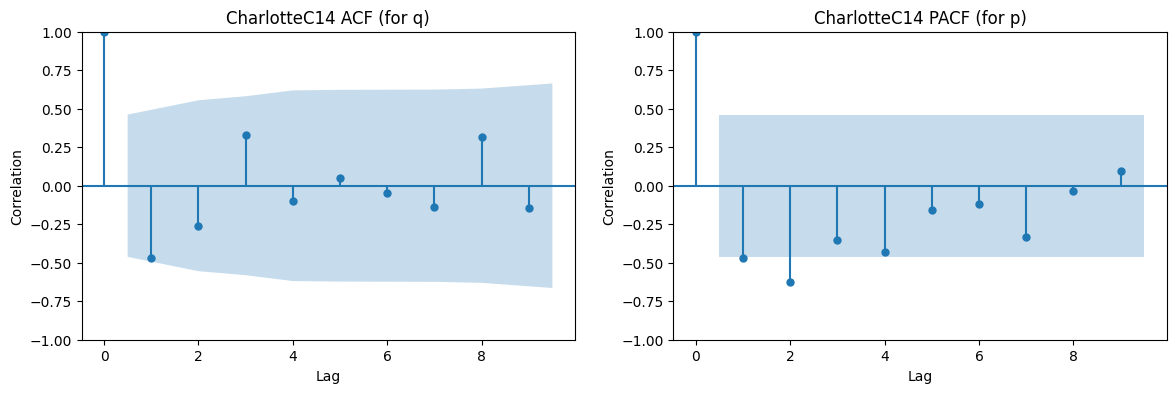

Order used for training: (10, 0, 0)


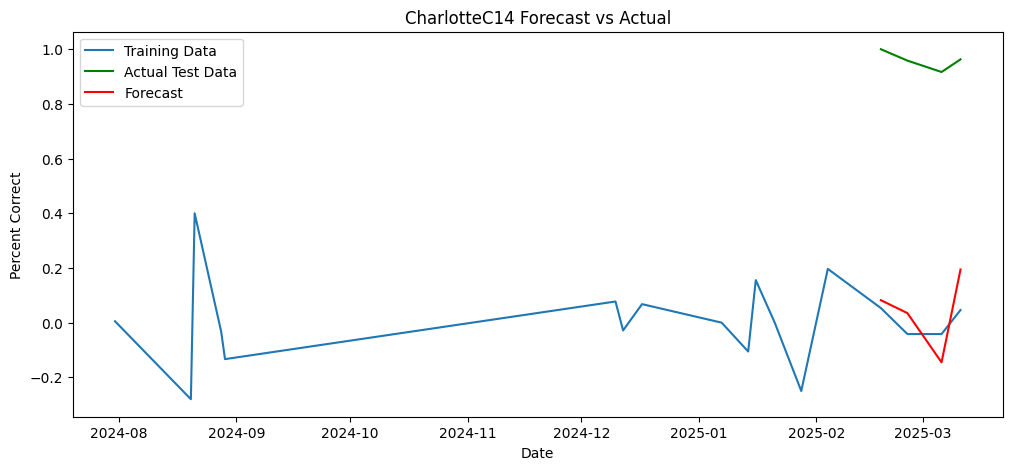

MAE: 0.92, RMSE: 0.92
CyrusC3
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -3.813369109460927
p-value: 0.0027734554173901365
Best Order: (1, 0, 1)


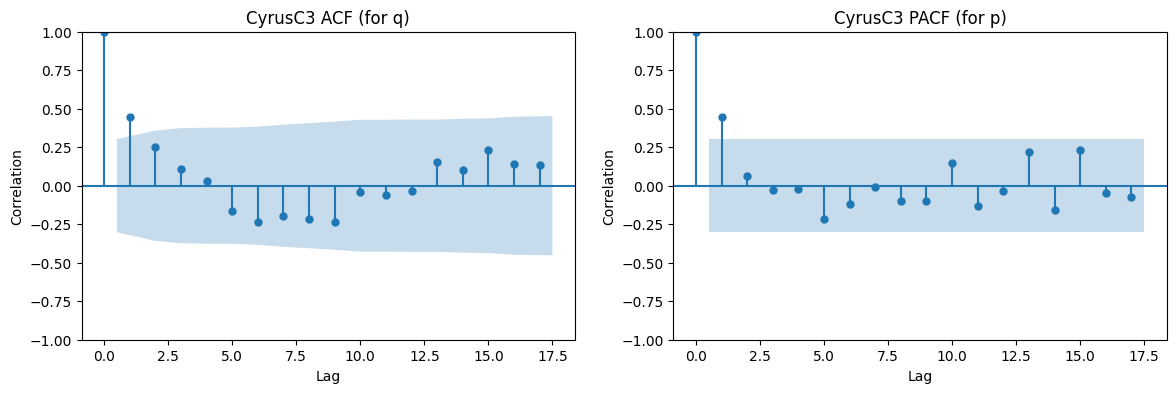

Order used for training: (10, 0, 0)


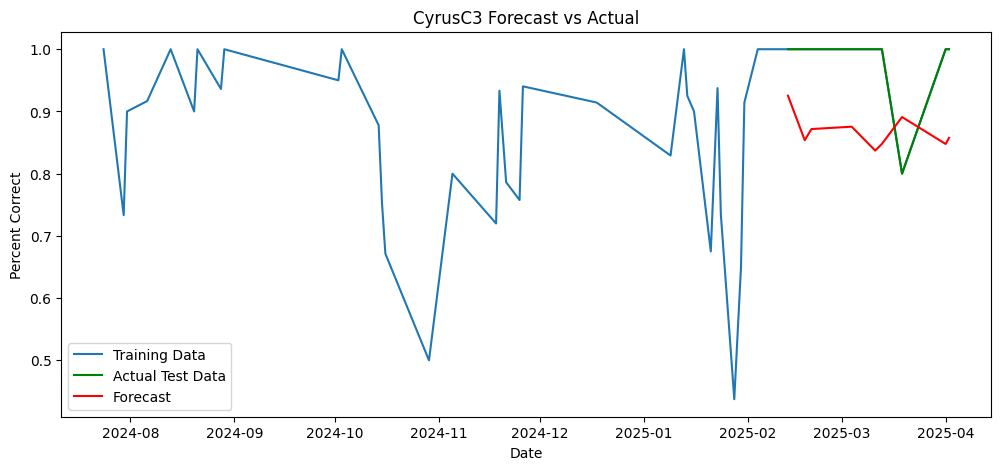

MAE: 0.13, RMSE: 0.13
FoxF2
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -0.9613542564556653
p-value: 0.7670972980156212
Best Order: (6, 1, 1)


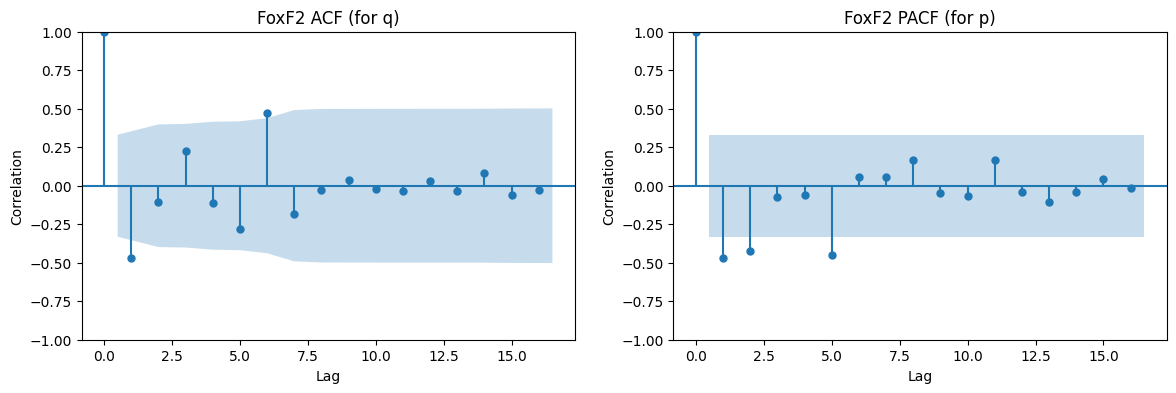

Order used for training: (10, 0, 0)


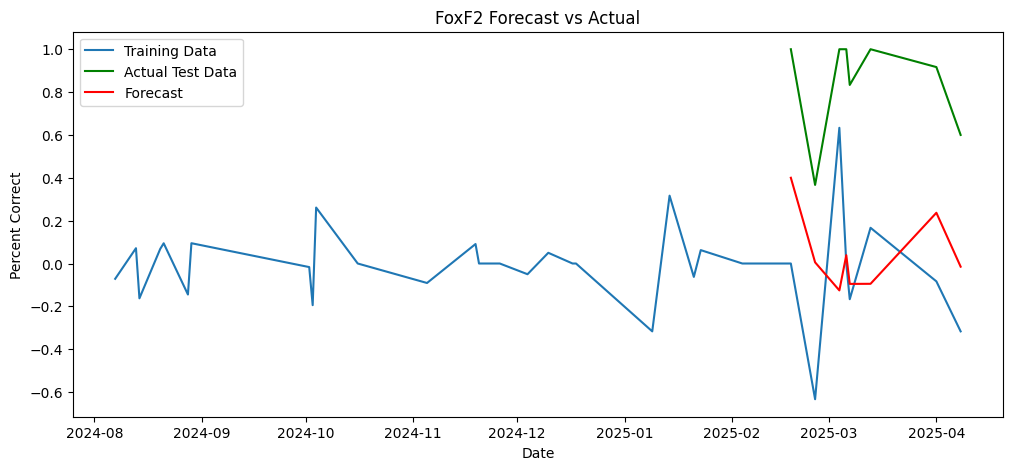

MAE: 0.80, RMSE: 0.84
KnoxK2
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.318869339477786
p-value: 0.16595443185224645
Best Order: (6, 1, 1)


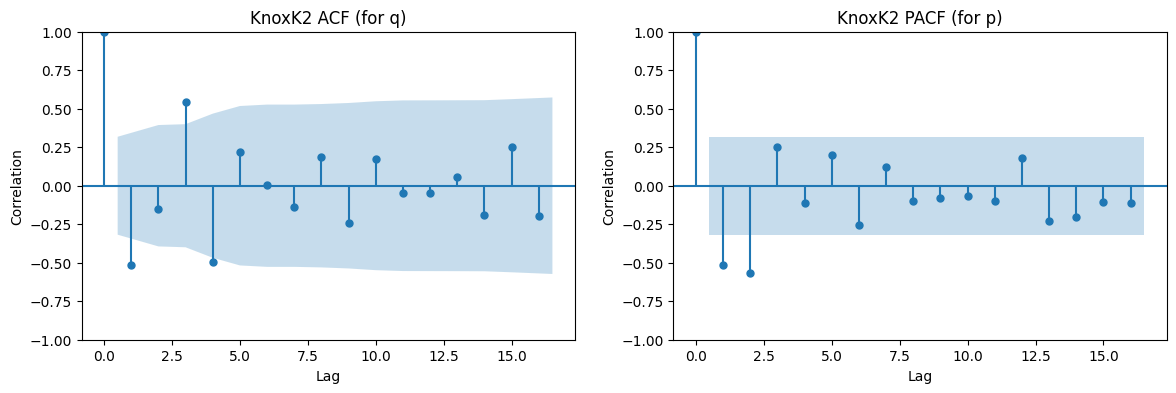

Order used for training: (10, 0, 0)


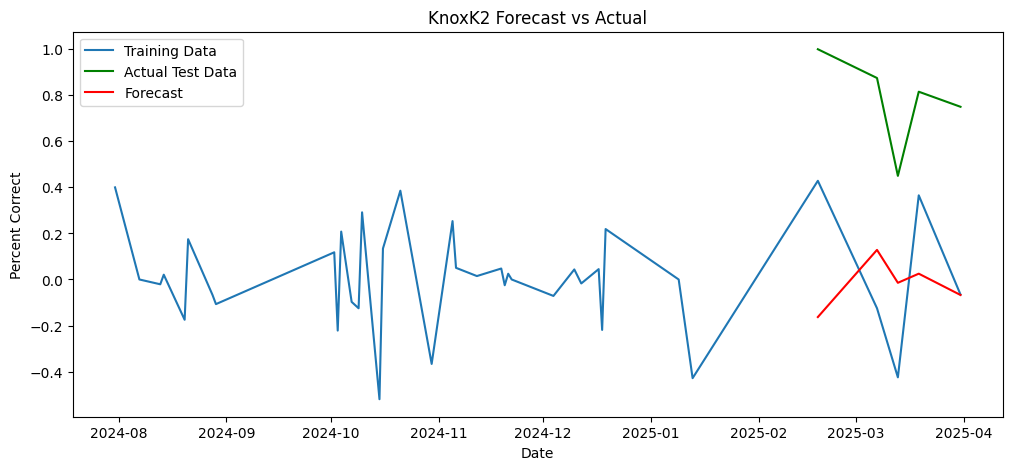

MAE: 0.80, RMSE: 0.83
PaytonP4
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -2.577322768106639
p-value: 0.09777535016416311
Best Order: (6, 1, 1)


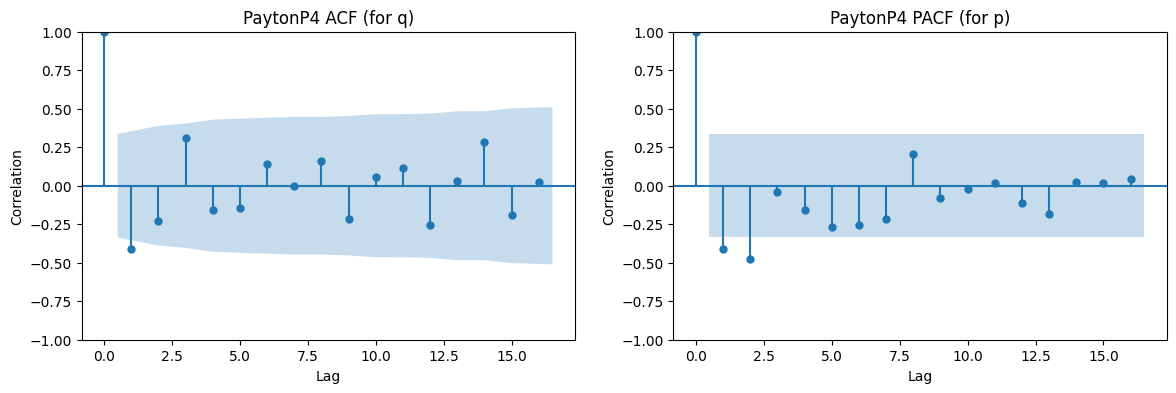

Order used for training: (10, 0, 0)


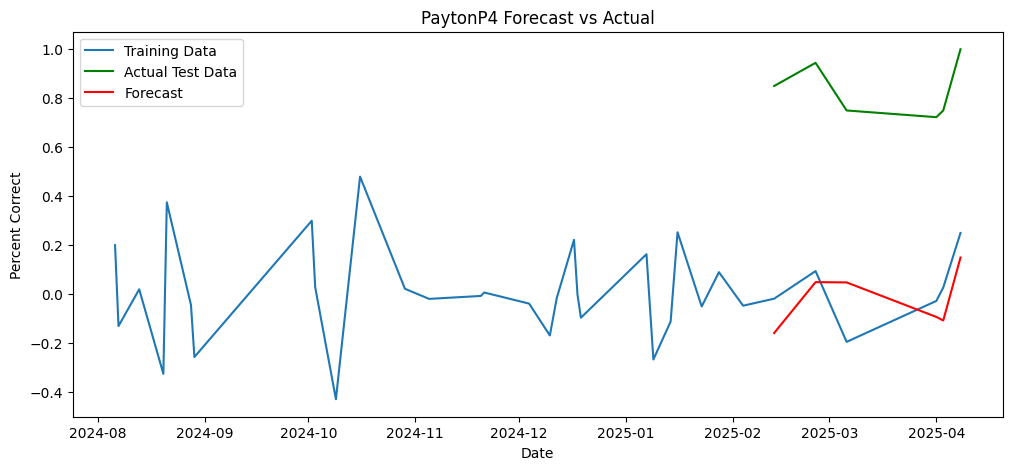

MAE: 0.85, RMSE: 0.86
OarielO
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: -1.629422034685263
p-value: 0.4677932579321218
Best Order: (1, 1, 1)


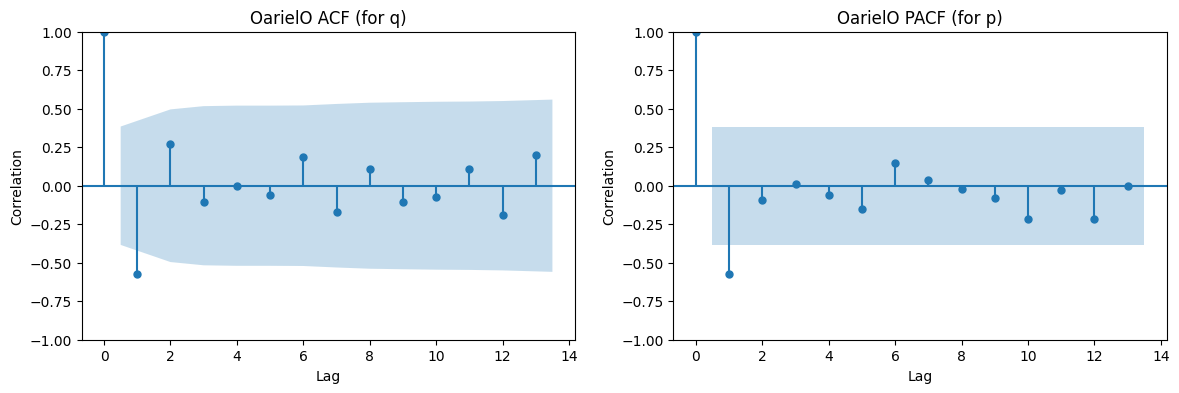

Order used for training: (10, 0, 0)


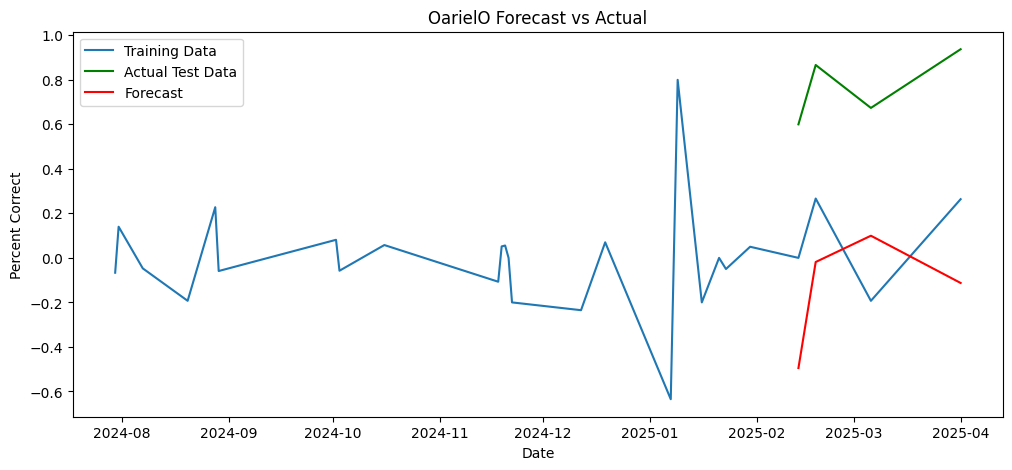

MAE: 0.90, RMSE: 0.92
AyaA2
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -5.867152336626031
p-value: 3.3049544930853404e-07
Best Order: (1, 0, 1)


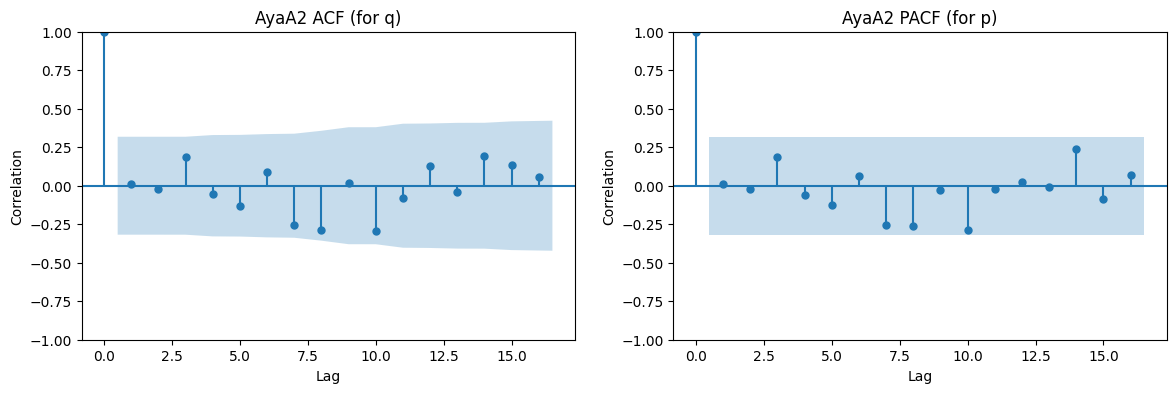

Order used for training: (10, 0, 0)


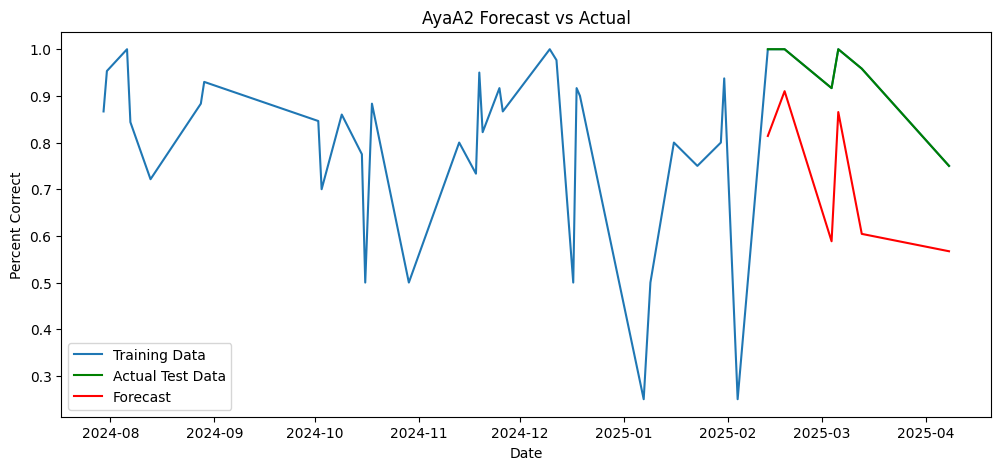

MAE: 0.21, RMSE: 0.23
OamirO
percent_correct is stationary, differencing not required (set d=0)
ADF Statistic: -2.955911421928937
p-value: 0.03922192089864981
Best Order: (1, 0, 1)


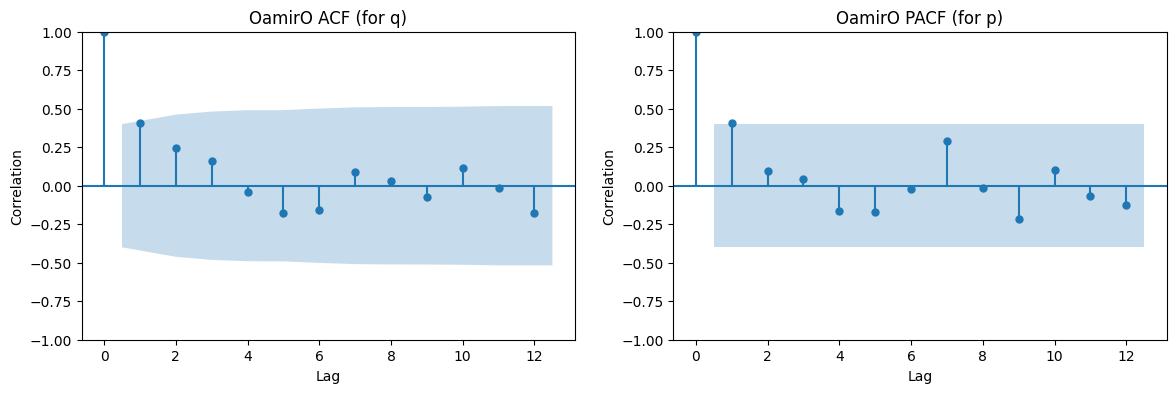

Order used for training: (10, 0, 0)


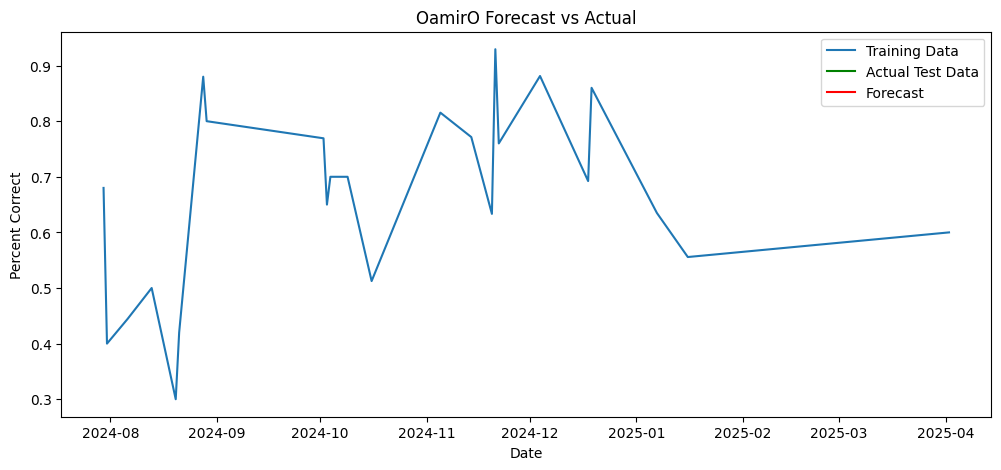

MAE: 0.05, RMSE: 0.05
IyanaI
percent_correct is not stationary, differencing is required (set d=1)
ADF Statistic: 3.5658506937777155
p-value: 1.0
Best Order: (1, 1, 1)


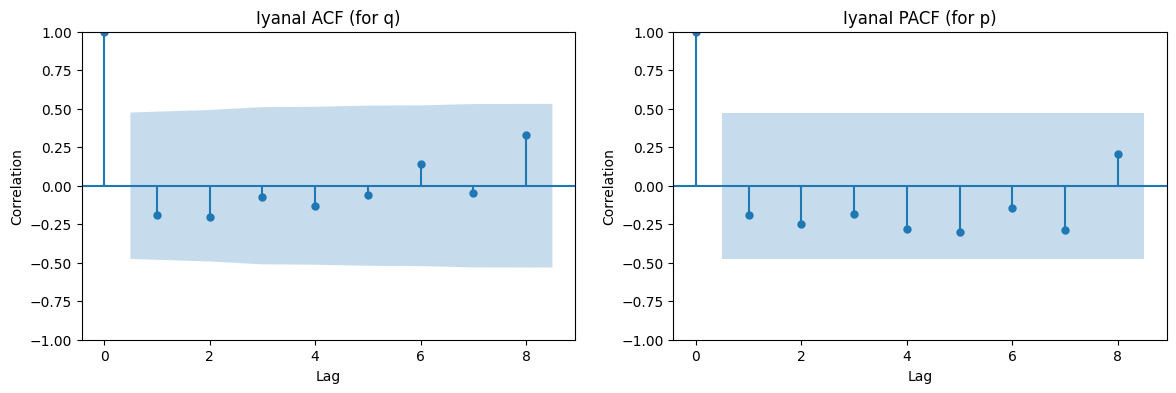

Order used for training: (10, 0, 0)


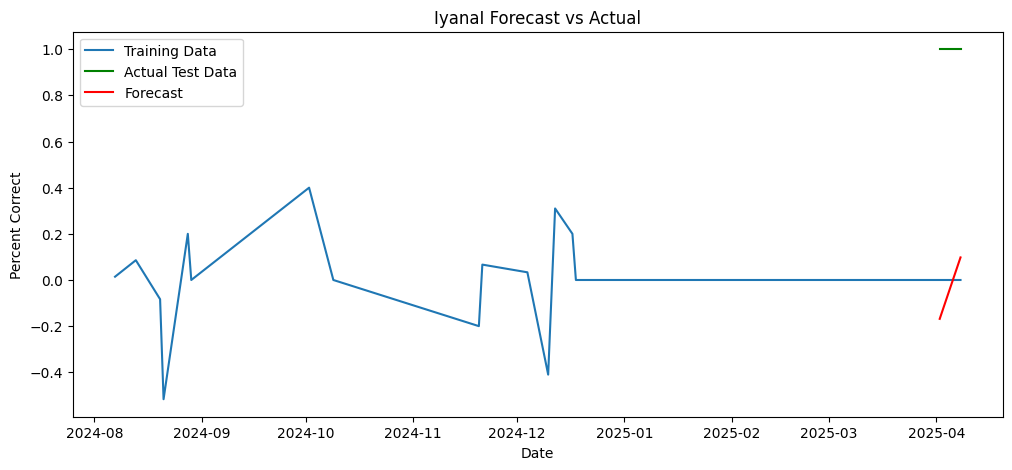

MAE: 1.04, RMSE: 1.04
Average MSE: 0.55
Average MAE: 0.63
Average RMSE: 0.65


In [11]:
'''
ARIMA model training: individual student data
- train model using school-level parameters (order = (10, 0, 0))
- forecast the test data
- compare with actual test data
- calculate MAE and RMSE
- visualize forecast vs actual
'''

mses = []
maes = []
rmses = []

def student_forecast(username):

  daily_avg_student, daily_avg_student_test, _ = student_tuning(username)
  order = (10, 0, 0)

  print (f'Order used for training: {order}')

  student_model = ARIMA(daily_avg_student, order=order)
  student_results = student_model.fit()

  n_forecast = len(daily_avg_student_test)
  forecast = student_results.forecast(steps=n_forecast)
  forecast.index = daily_avg_student_test.index

  plt.figure(figsize=(12, 5))
  plt.plot(daily_avg_student, label='Training Data')
  plt.plot(daily_avg_student_test, label='Actual Test Data', color='green')
  plt.plot(forecast, label='Forecast', color='red')
  plt.legend()
  plt.title(f'{username} Forecast vs Actual')
  plt.xlabel('Date')
  plt.ylabel('Percent Correct')
  plt.show()

  mae = mean_absolute_error(daily_avg_student_test, forecast)
  mse = mean_squared_error(daily_avg_student_test, forecast)
  rmse = mse ** 0.5

  mses.append(mse)
  maes.append(mae)
  rmses.append(rmse)

  print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

for username in usernames:
  student_forecast(username)

av_mse = np.mean(mses)
av_mae = np.mean(maes)
av_rmse = np.mean(rmses)

print(f'Average MSE: {av_mse:.2f}')
print(f'Average MAE: {av_mae:.2f}')
print(f'Average RMSE: {av_rmse:.2f}')